This is part of a series of notebooks about practical time series methods:

* [Part 0: the basics](https://www.kaggle.com/konradb/ts-0-the-basics) - **this notebook**
* [Part 1a: smoothing methods](https://www.kaggle.com/konradb/ts-1a-smoothing-methods)
* [Part 1b: Prophet](https://www.kaggle.com/konradb/ts-1b-prophet) 
* [Part 2: ARMA](https://www.kaggle.com/konradb/ts-2-arma-and-friends)
* [Part 3: Time series for finance](https://www.kaggle.com/konradb/ts-3-time-series-for-finance) 
* [Part 4: Sales and demand forecasting](https://www.kaggle.com/konradb/ts-4-sales-and-demand-forecasting)
* [Part 5: Automatic for the people](https://www.kaggle.com/code/konradb/ts-5-automatic-for-the-people) 
* [Part 6: Deep learning for TS - sequences](https://www.kaggle.com/konradb/ts-6-deep-learning-for-ts-sequences)
* [Part 7: Survival analysis](https://www.kaggle.com/konradb/ts-7-survival-analysis)
* [Part 8: Hierarchical time series](https://www.kaggle.com/code/konradb/ts-8-hierarchical-time-series)


The series is accompanied by video presentations on the YouTube channel of [Abhishek](https://www.kaggle.com/abhishek):

* [Talk 0](https://www.youtube.com/watch?v=cKzXOOtOXYY) - **based on this notebook**
* [Talk 1](https://www.youtube.com/watch?v=kAI67Sz92-s) - combining the content from parts 1a and 1b
* [Talk 2](https://www.youtube.com/watch?v=LjV5DE3KR-U) 
* [Talk 3](https://www.youtube.com/watch?v=74rDhJexmTg)
* [Talk 4](https://www.youtube.com/watch?v=RdH8zd07u2E) 
* [Talk 5](https://www.youtube.com/watch?v=wBP8Pc4Wxzs)
* [Talk 6](https://www.youtube.com/watch?v=81AEI0tj0Kk)
* [Talk 7](https://www.youtube.com/watch?v=m-8I_hkmz9o)
* [Talk 8]()


**If you think this notebook deserves an upvote, I'd love to have it. An upvote per view, its all I ask**
(credit to [Dan Carlin](https://twitter.com/HardcoreHistory) for coining the phrase ;-) 


---------------------------------------


This notebook summarizes some elementary methods for time series analysis - sometimes you don't have the time / hardware / data to go for a Transformer, and vintage methods can be your friend. There is more content where that came from (based on a course I used to teach), so further installments will involve ARIMA, state space methods (and eventually sequence models - because #DeepLearnEverything ;-) 

* [Groundwork](#section-one)
* [Patterns](#section-two)
* [Dependence](#section-three)
* [Stationarity](#section-four)


We start by importing the necessary libraries - most of them are familiar to anybody working with the data science, with the exception of statsmodels. It is a product of impressive work by Seabold and Perktold (http://conference.scipy.org/proceedings/scipy2010/pdfs/seabold.pdf) - two people who set out to bring statistical functionality in Python into the 21st century. If you are likely to use statistics in your work and you are a Pythonista, familiarizing yourself with this library is a very good idea: 

https://www.statsmodels.org/stable/index.html

In this module we are merely scratching the surface of statsmodel functionality, with seasonal decomposition as our primary tool.

In [1]:
import pandas as pd
import numpy as np
from random import gauss
from pandas.plotting import autocorrelation_plot
import warnings
import itertools
from random import random

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# import matplotlib as mpl
import seaborn as sns     


In [13]:
# general settings
class CFG:
    # data_folder = '../input/tsdata-1/'
    data_folder = 'data/'
    img_dim1 = 40
    img_dim2 = 20
    
    
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})   
plt.rcParams['lines.linewidth'] = 2.0 

<a id="section-one"></a>
# Groundwork


TL;DR Time series is any sequence you record over time and applications are everywhere.



More formally, time series data is a sequence of data points (or observations) recorded at different time intervals - those intervals are frequently, but not always, regular (hourly, daily, weekly, monthly, quarterly etc): 

\begin{equation}
\{X_t\} \quad t= 1,\ldots,T 
\end{equation}

A strict formulation would be that a time series (discrete) realization of a (continuous) stochastic process generating the data and the underlying reason why we can infer from the former about the latter is the Kolmogorov extension theorem. The proper mathematical treatment of this theory is way beyond the scope of this notebook, so a mathematically inclinded reader is advised to look up those terms and then follow the references. 

Phenomena measured over time are everywhere, so a natural question is: what can we do with time series? Some of the more popular applications / reasons to bother are:

* interpretation: we want to be able to make sense of diverse phenomena and capture the nature of the underlying dynamics
* modelling: understanding inherent aspects of the time series data so that we can create meaningful and accurate forecasts.
* **forecasting / prediction**: we want to know something about the future :-) 
* filtering / smoothing: we want to get a better understanding of the process based on partially / fully observed sample
* simulation: in certain applications calculating e.g. high quantiles of a distribution is only possible with simulation, because there is not enough historical data

Some useful references include:

    * Brockwell and Davies "Time Series: Theory and Methods"
    * Shumway and Stoffer "Time Series Analysis and Its Applications"
    * Durbin and Koopman "Time Series Analysis by State Space Methods"
    * Just about anything written by **Rob Hyndman** https://robjhyndman.com/
    * Ross Ihaka "Time Series Analysis": https://www.stat.auckland.ac.nz/~ihaka/726/notes.pdf

<a id="section-two"></a>
# Patterns

The first we can do to identify patterns in a time series is separate it into components with easily understandable characteristics:

\begin{equation}
X_t = T_t + S_t + C_t + I_t \quad 
\end{equation}

where: 
* $T_t$: the trend shows a general direction of the time series data over a long period of time. It represents a long-term progression of the series (secular variation)  

* $S_t$: the seasonal component with fixed and known period. It is observed when there is a distinct repeated pattern observed between regular intervals due to seasonal factors: annual, monthly or weekly. Obvious examples include daily power consumption patterns or annual sales of seasonal goods.

* $C_t$: (optional) cyclical component is a repetitive pattern which does not occur at fixed intervals - usually observed in an economic context like business cycles. 

* $I_t$: the irregular component (residuals ) consists of the fluctuations in the time series that are observed after removing trend and seasonal / cyclical variations. 

We may have different combinations of trends and seasonality. Depending on the nature of the trends and seasonality, a time series can be modeled as an additive or multiplicative time series. Each observation in the series can be expressed as either a sum or a product of the components.


It is worth pointing out that an alternative to using a multiplicative decomposition is to first transform the data until the variation in the series appears to be stable over time, then use an additive decomposition. When a log transformation has been used, this is equivalent to using a multiplicative decomposition because
\begin{equation}
X_t = T_t * S_t * I_t
\end{equation}

is equivalent to 

\begin{equation}
log X_t = log T_t + log S_t + log I_t
\end{equation}


A popular implementation for calculating the fundamental decomposition can be used via the statsmodels package:

In [3]:
help(seasonal_decompose)

Help on function seasonal_decompose in module statsmodels.tsa.seasonal:

seasonal_decompose(x, model='additive', filt=None, period=None, two_sided=True, extrapolate_trend=0)
    Seasonal decomposition using moving averages.
    
    Parameters
    ----------
    x : array_like
        Time series. If 2d, individual series are in columns. x must contain 2
        complete cycles.
    model : {"additive", "multiplicative"}, optional
        Type of seasonal component. Abbreviations are accepted.
    filt : array_like, optional
        The filter coefficients for filtering out the seasonal component.
        The concrete moving average method used in filtering is determined by
        two_sided.
    period : int, optional
        Period of the series. Must be used if x is not a pandas object or if
        the index of x does not have  a frequency. Overrides default
        periodicity of x if x is a pandas object with a timeseries index.
    two_sided : bool, optional
        The moving a

## Examples

### Passengers dataset

Every field of knowledge has **the** dataset that is used for teaching purposes: machine learning has Iris and CIFAR, differential equations - Canadian lynx data, and statistics has the airline passengers dataset between 1949 and 1960, first compiled by Box and Jenkins (you will be hearing those two names again in the next module) in 1976. We will use this dataset to demonstrate in practice what kind of information can be obtained using seasonal decomposition.

<!-- Box, G. E. P., Jenkins, G. M. and Reinsel, G. C. (1976) Time Series Analysis, Forecasting and Control. Third Edition. Holden-Day. Series G. -->

<AxesSubplot:xlabel='date'>

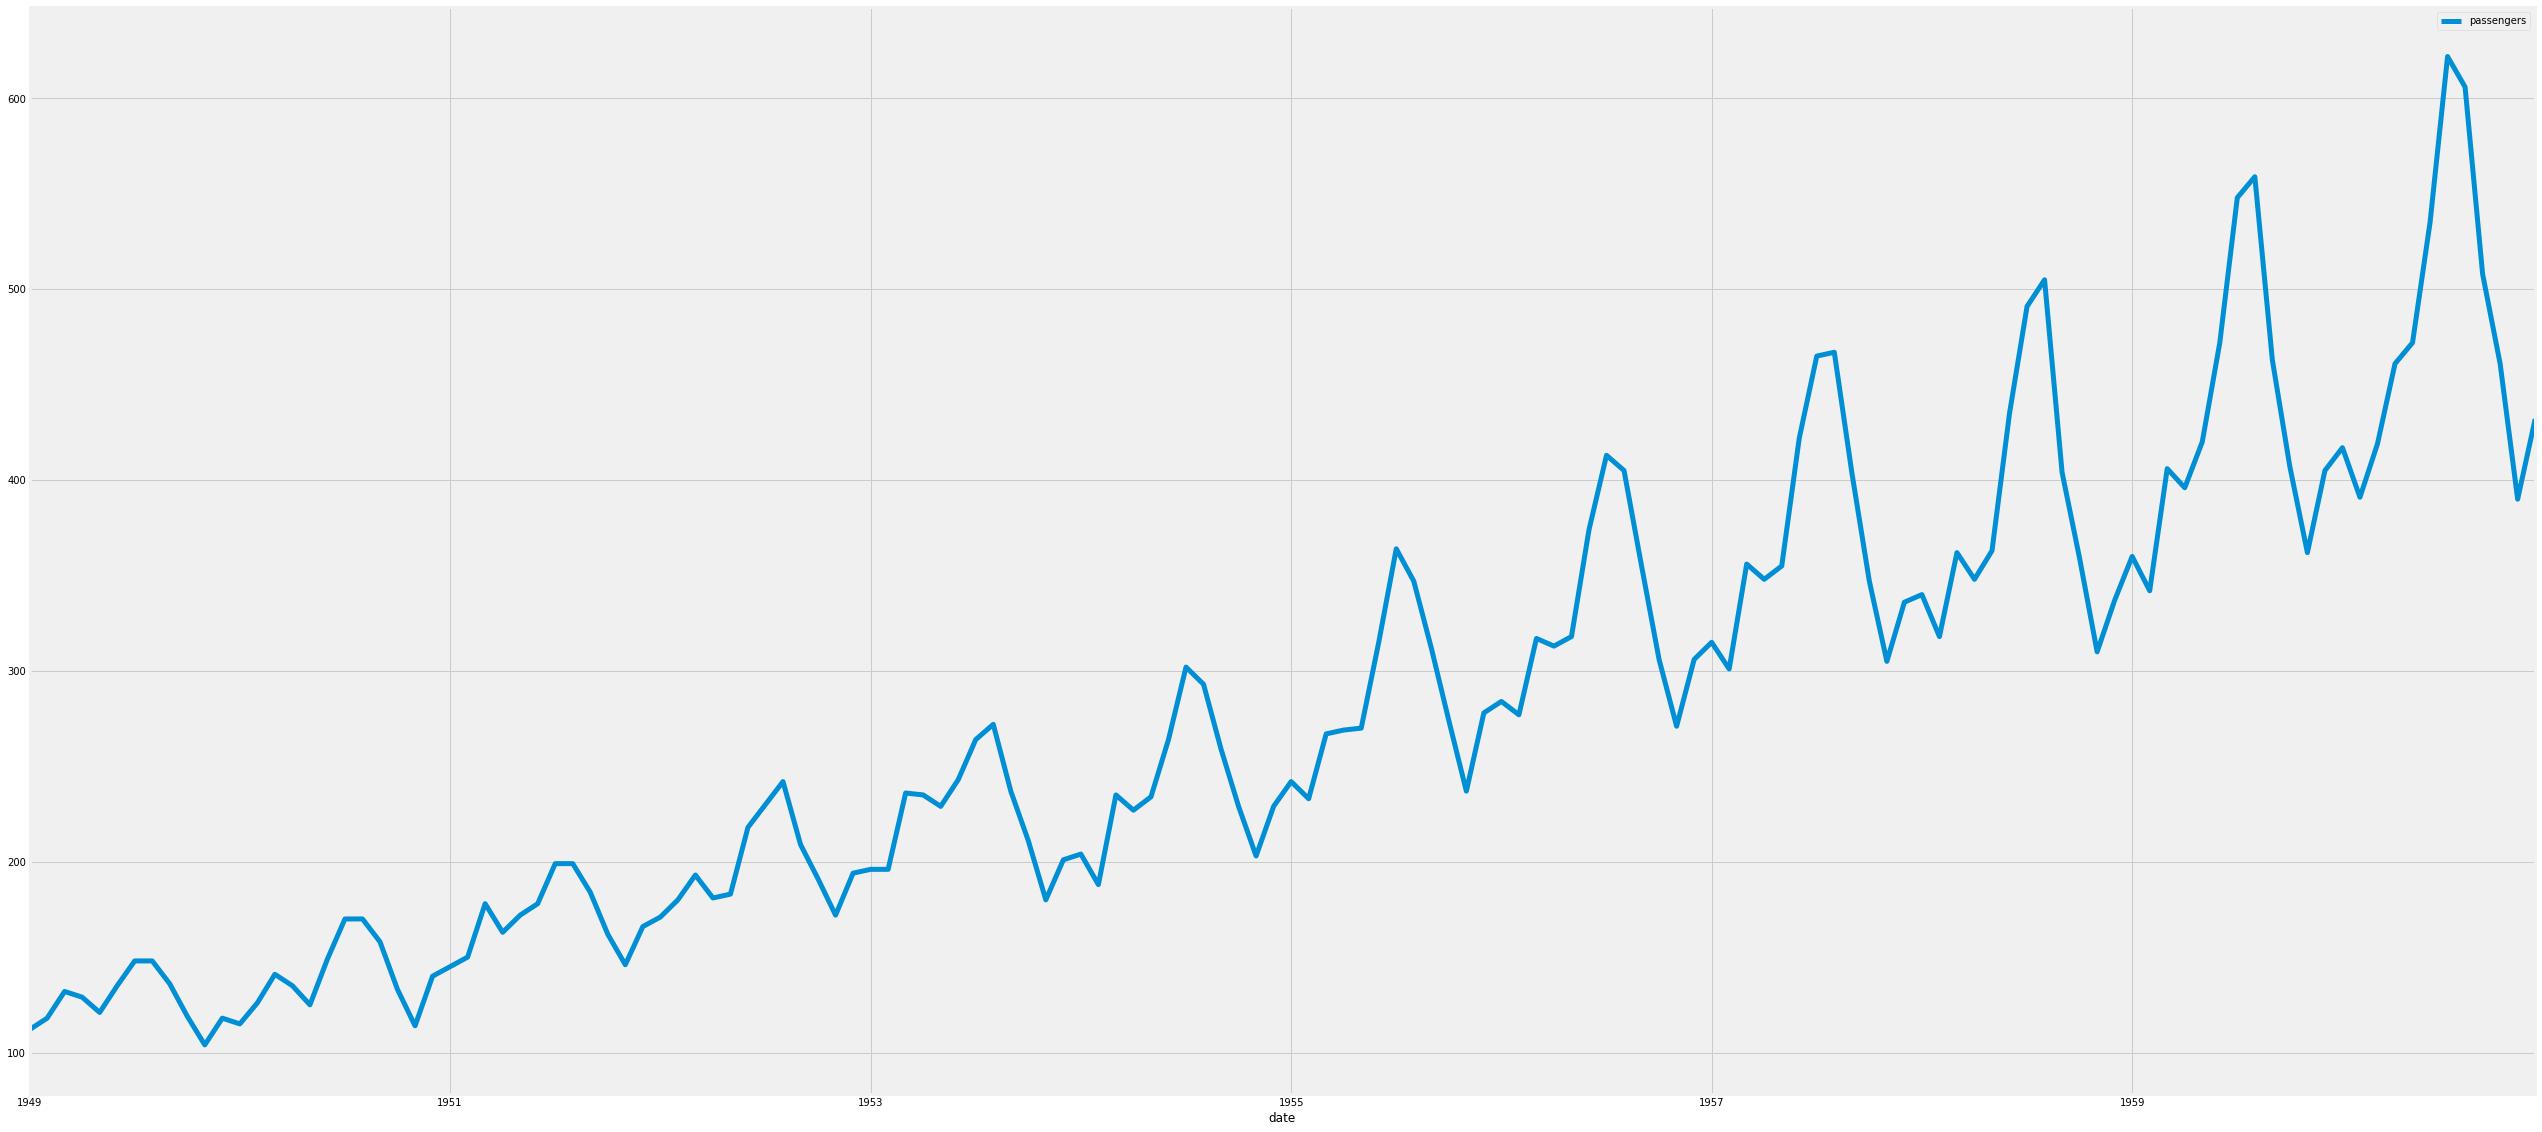

In [15]:
plt.rcParams['lines.linewidth'] = 5.0
series = pd.read_csv(CFG.data_folder + 'passengers.csv')
series['date'] = pd.to_datetime(series['date'])
series.set_index('date').plot()


Let's start with a basic additive decomposition:

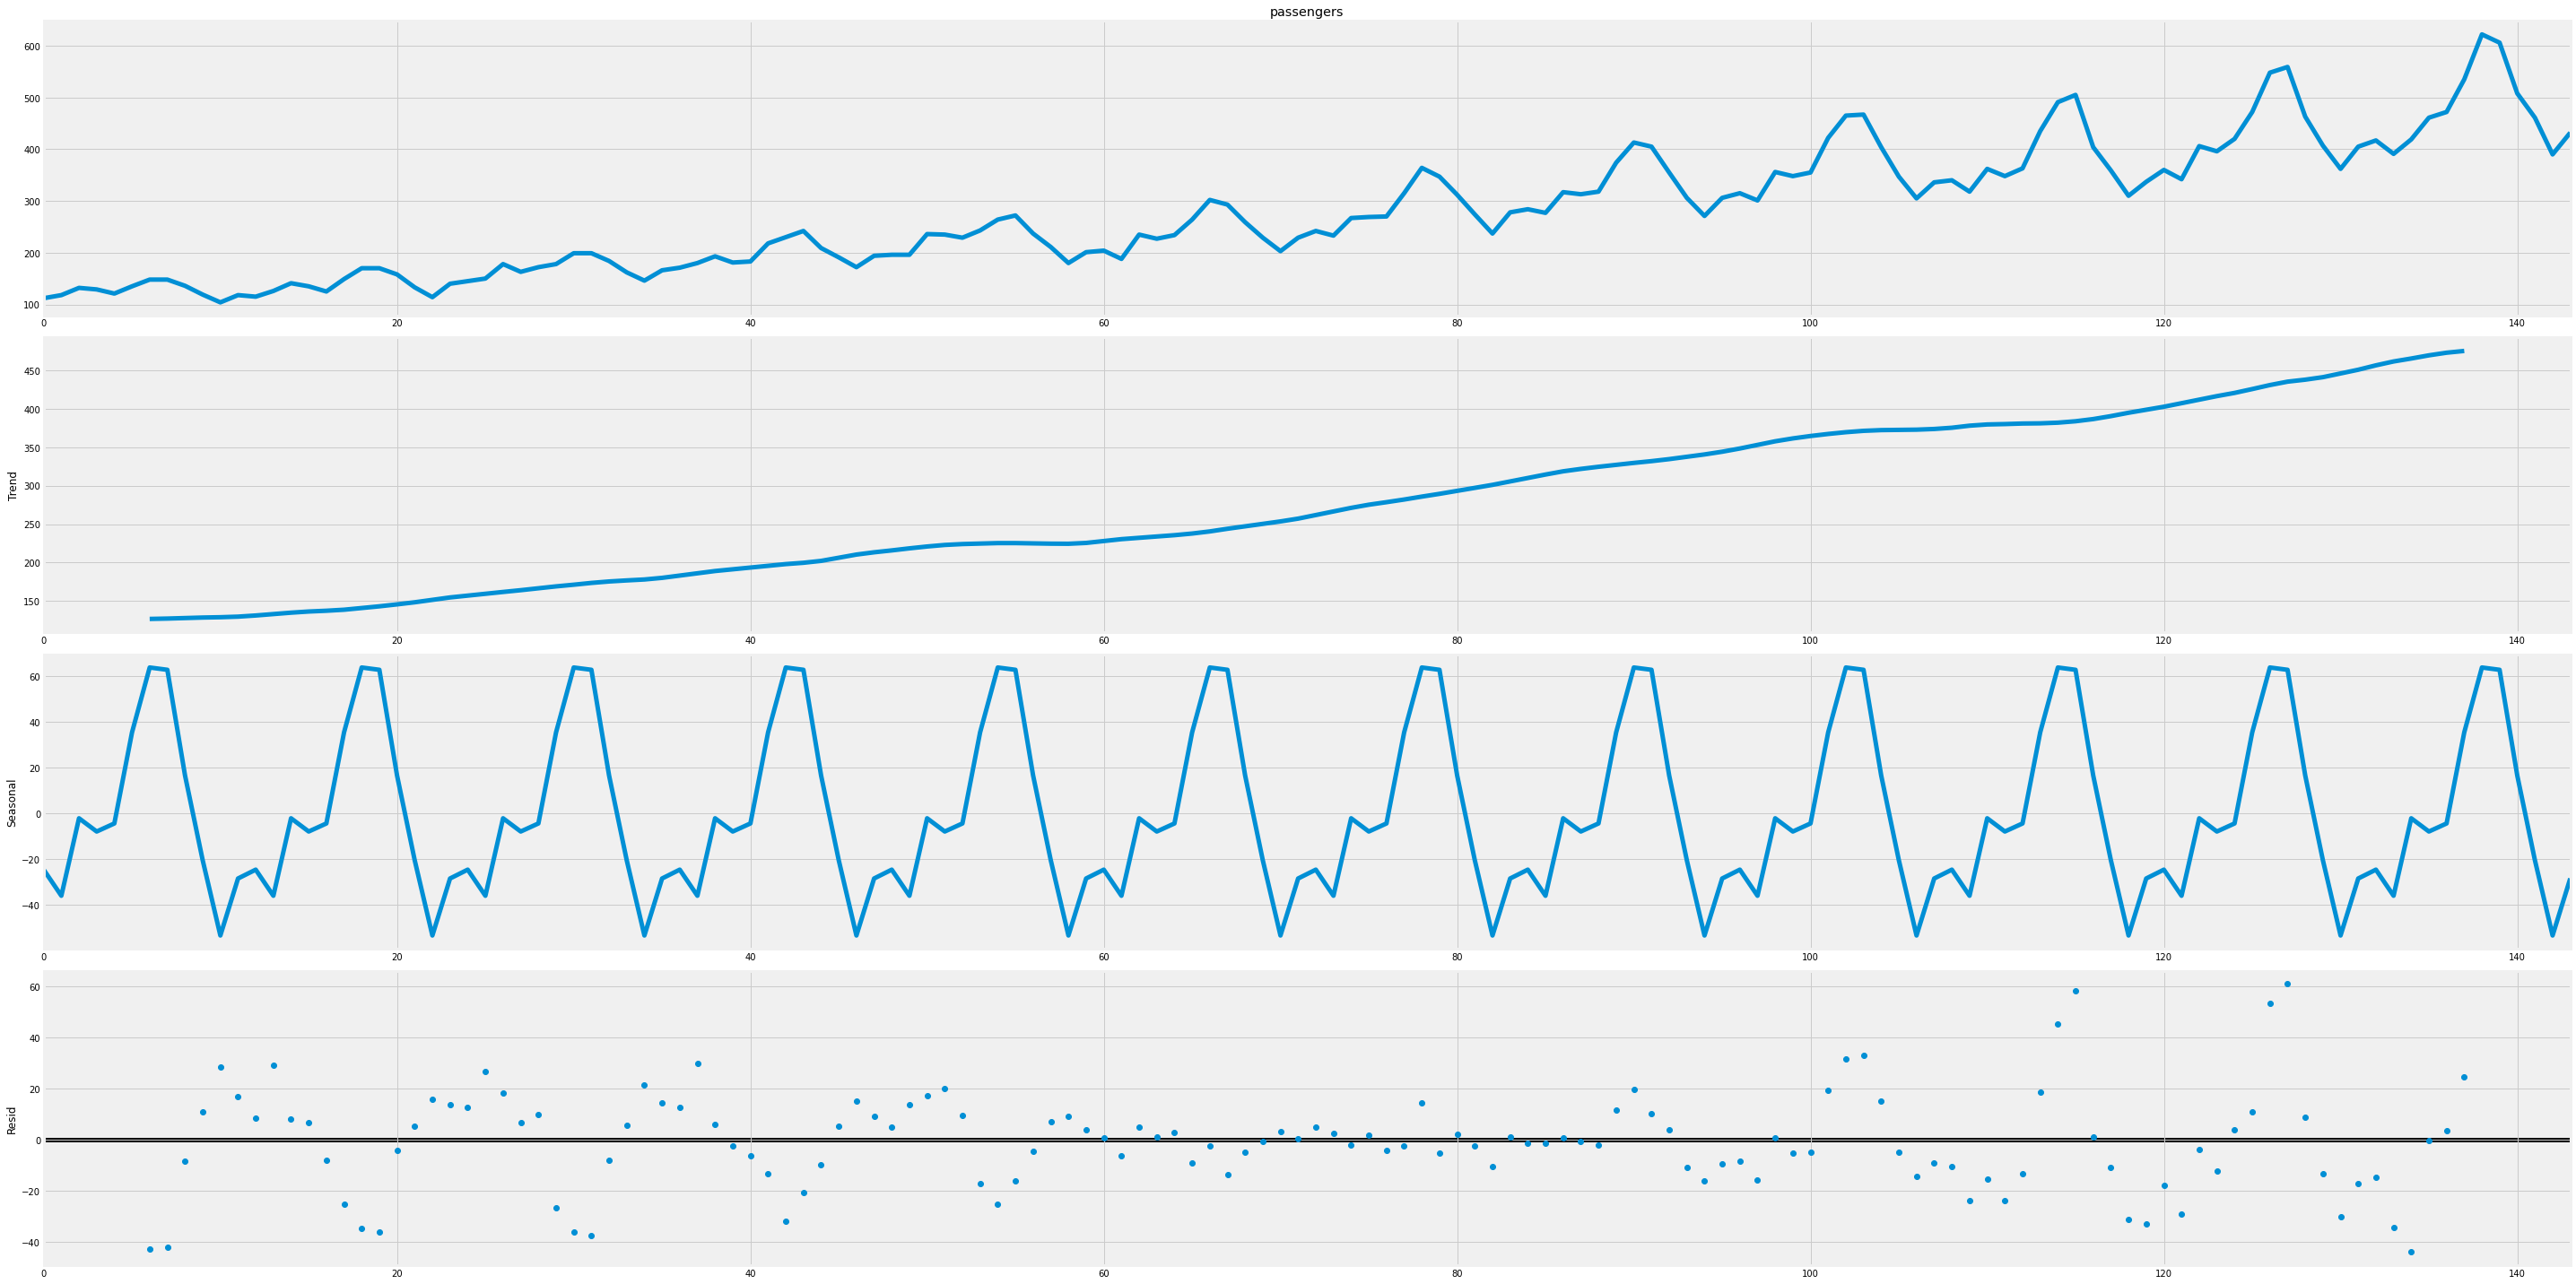

In [16]:
# decomposition
decomposition = sm.tsa.seasonal_decompose(series["passengers"],period =12) 
figure = decomposition.plot()
plt.show()

Trend and seasonality are behaving more or less in line with expectations, but the behavior of the residuals is clearly not consistent over time (average level of oscillations in the middle of the sample is very different than on either end). While there are many possible reasons, one quick explanation is the additive vs multiplicative relationship between the series components - which is something we can examine quickly:

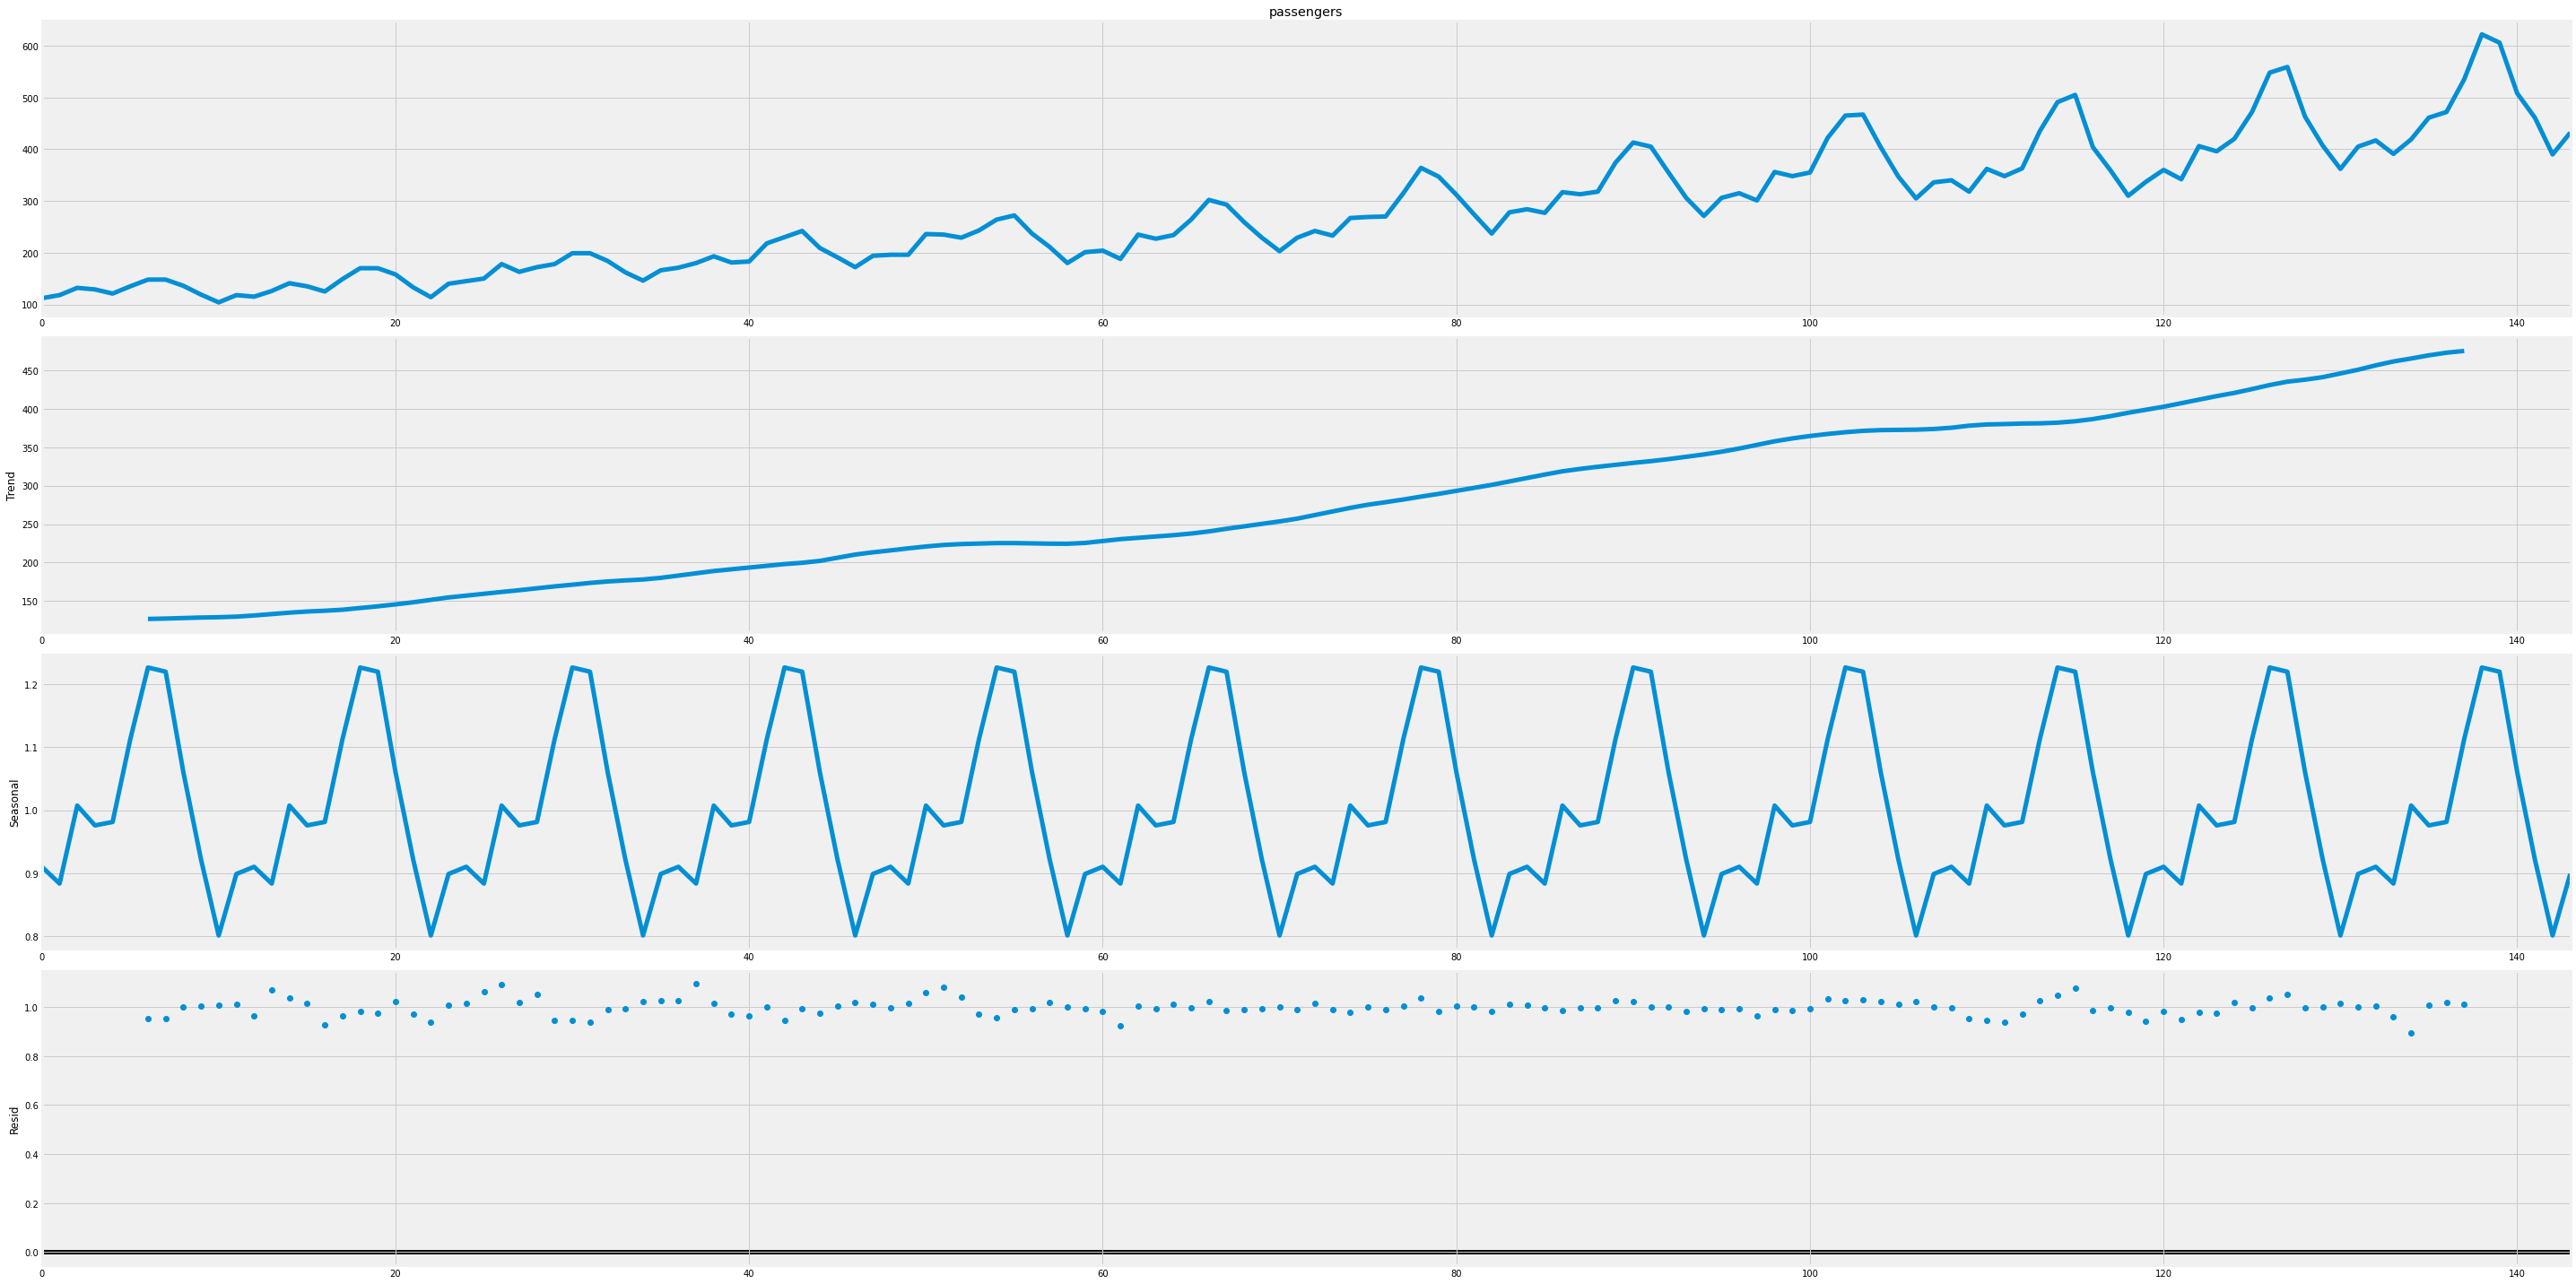

In [17]:
decomposition = sm.tsa.seasonal_decompose(series["passengers"],period =12, model = 'multiplicative') 
figure = decomposition.plot()
plt.show()

Not much of a qualitative change in trend and seasonality components, but the residuals looks much more stable around a constant level - such phenomenon does not of course imply stationarity by itself, but at least a clear signal in the opposite direction is not there anymore. 

### Changes in level of savings in the US

Let's check how does seasonal decomposition work with some other popular datasets:

<AxesSubplot:xlabel='date'>

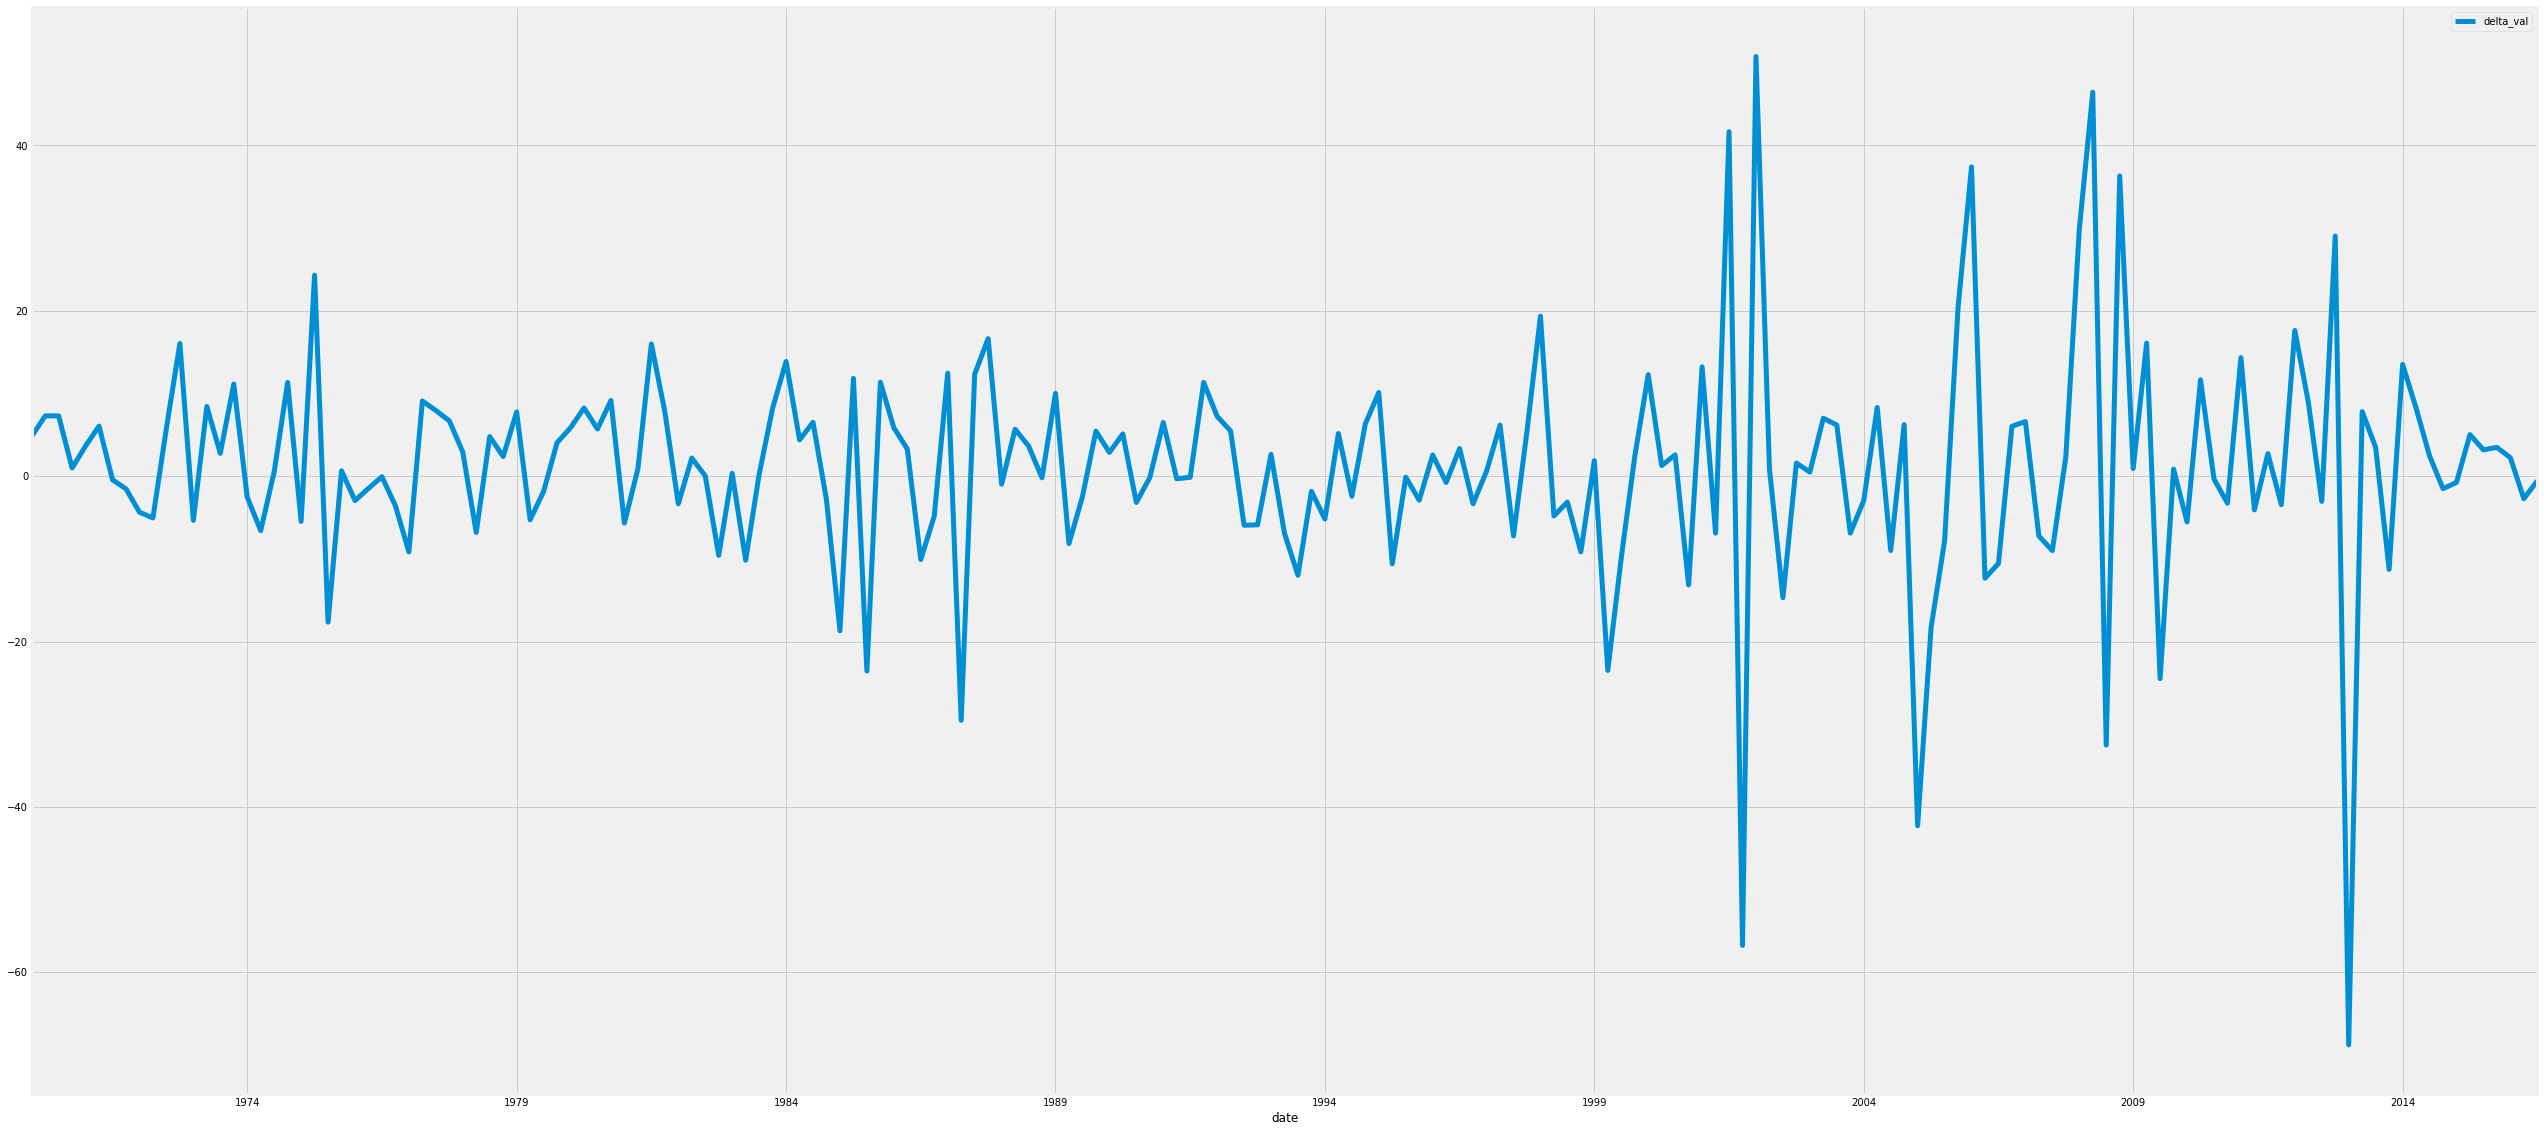

In [18]:
series = pd.read_csv(CFG.data_folder + 'savings_change.csv')
series['date'] = pd.to_datetime(series['date'])
series.set_index('date').plot()


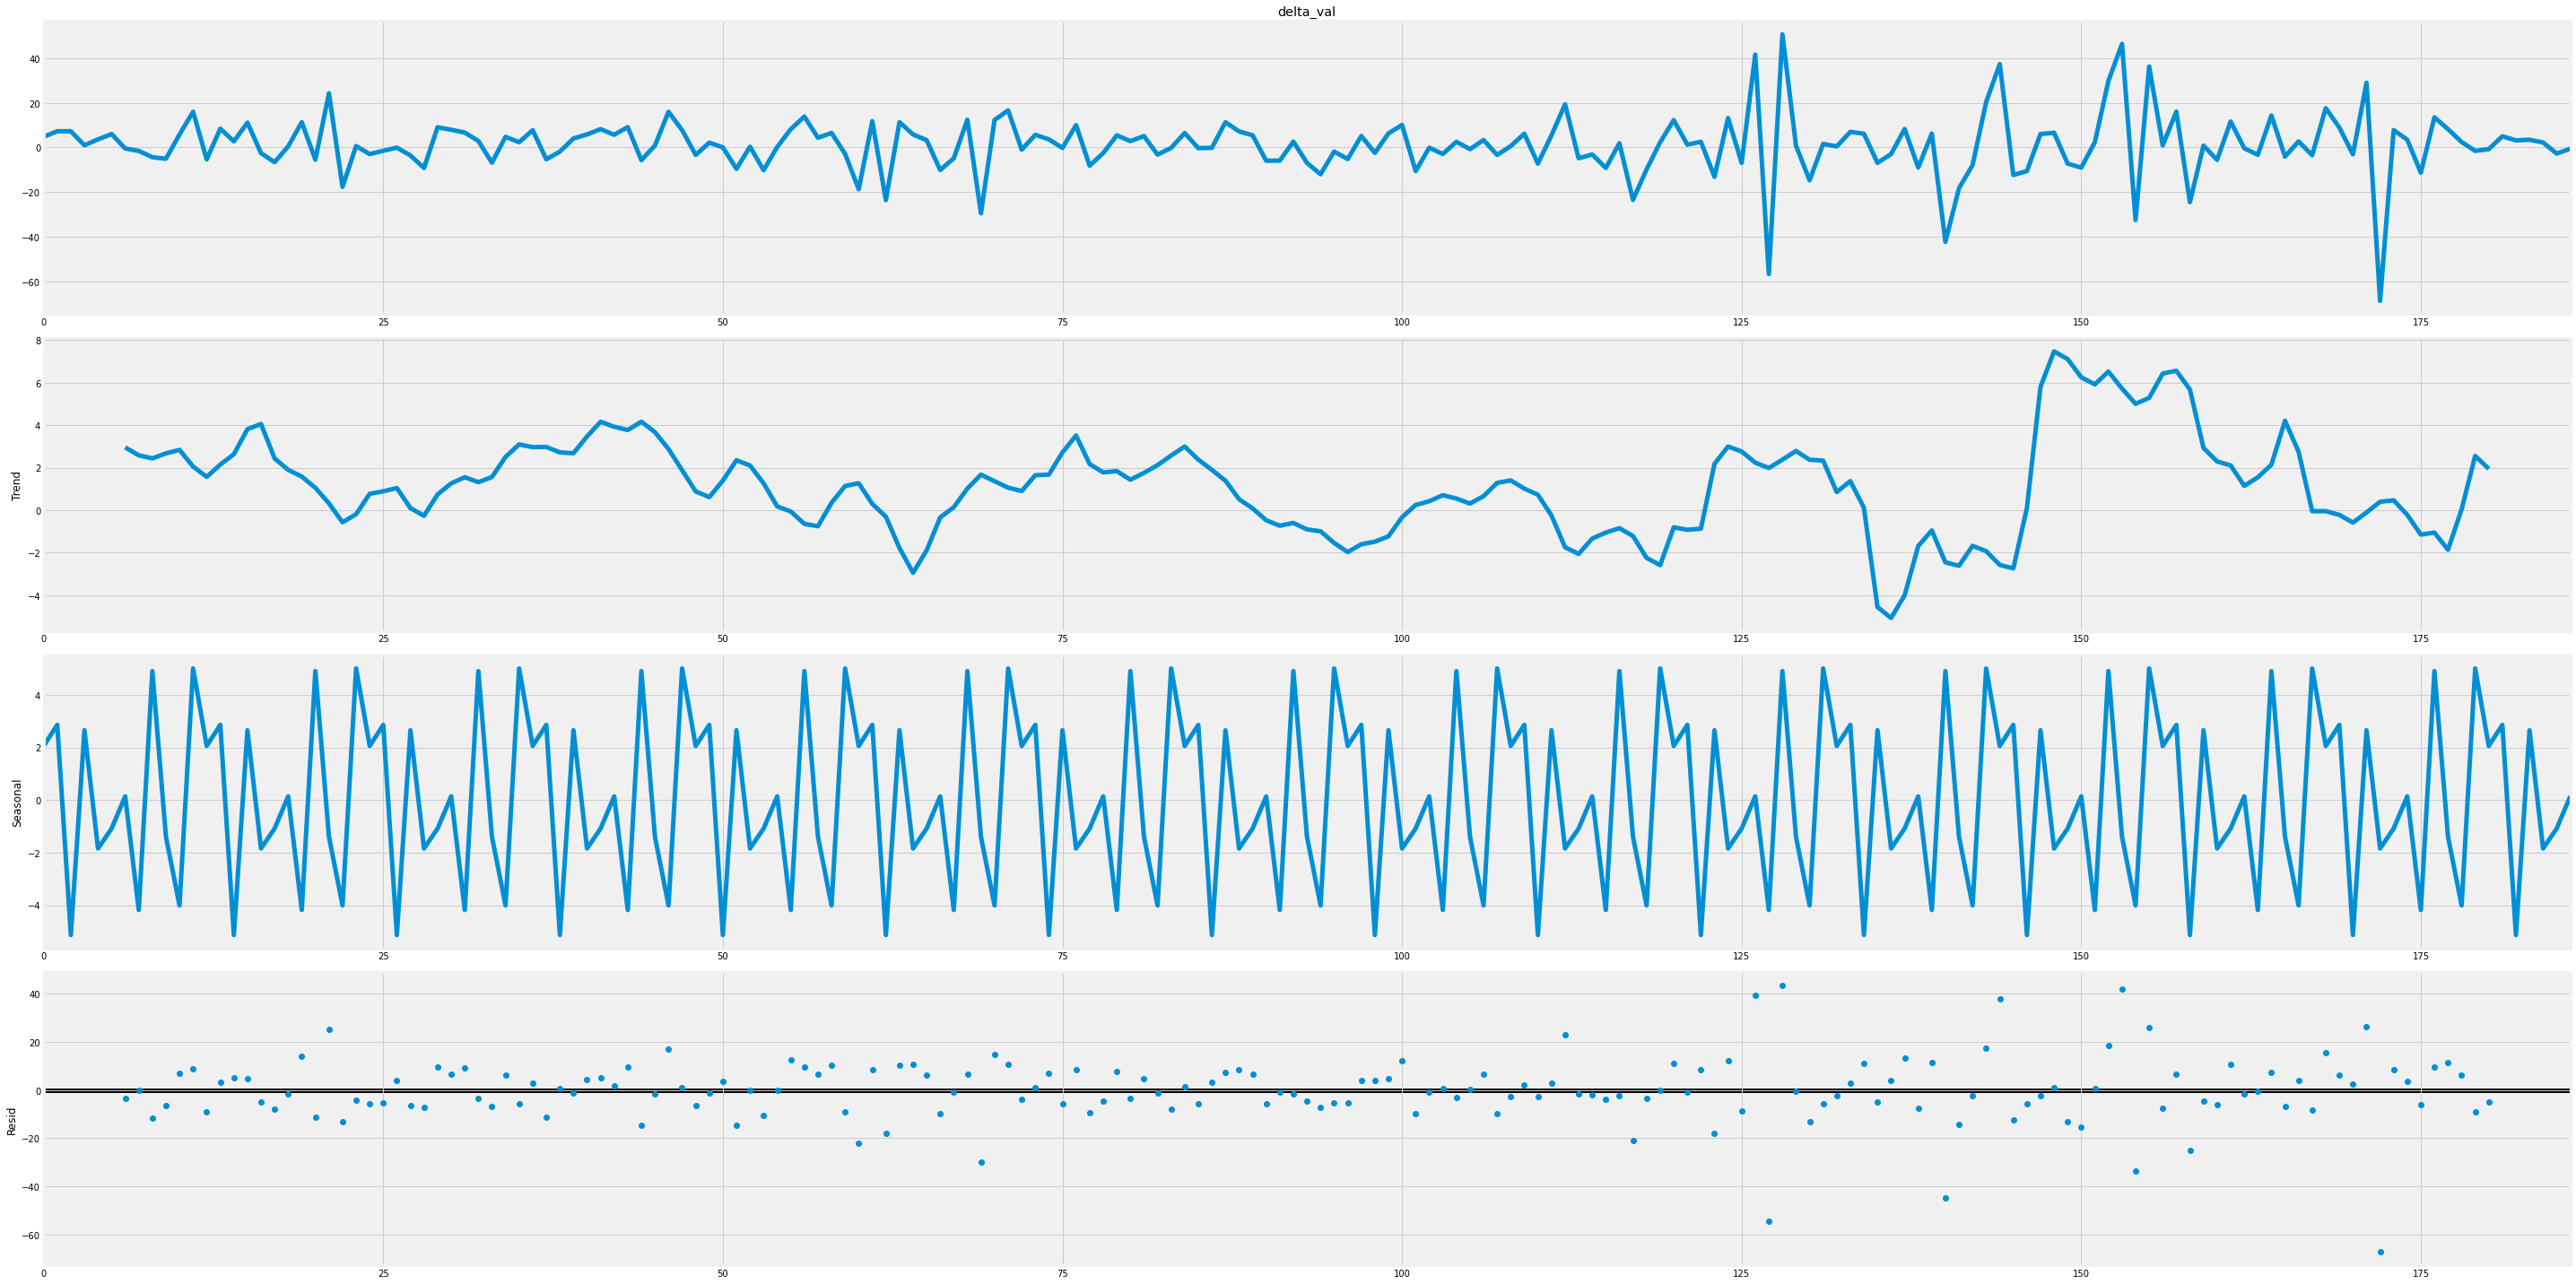

In [19]:
# decomposition
decomposition = sm.tsa.seasonal_decompose(series["delta_val"],period =12) 
figure = decomposition.plot()
plt.show()

### Annual averages of the daily sunspot areas

<AxesSubplot:xlabel='date'>

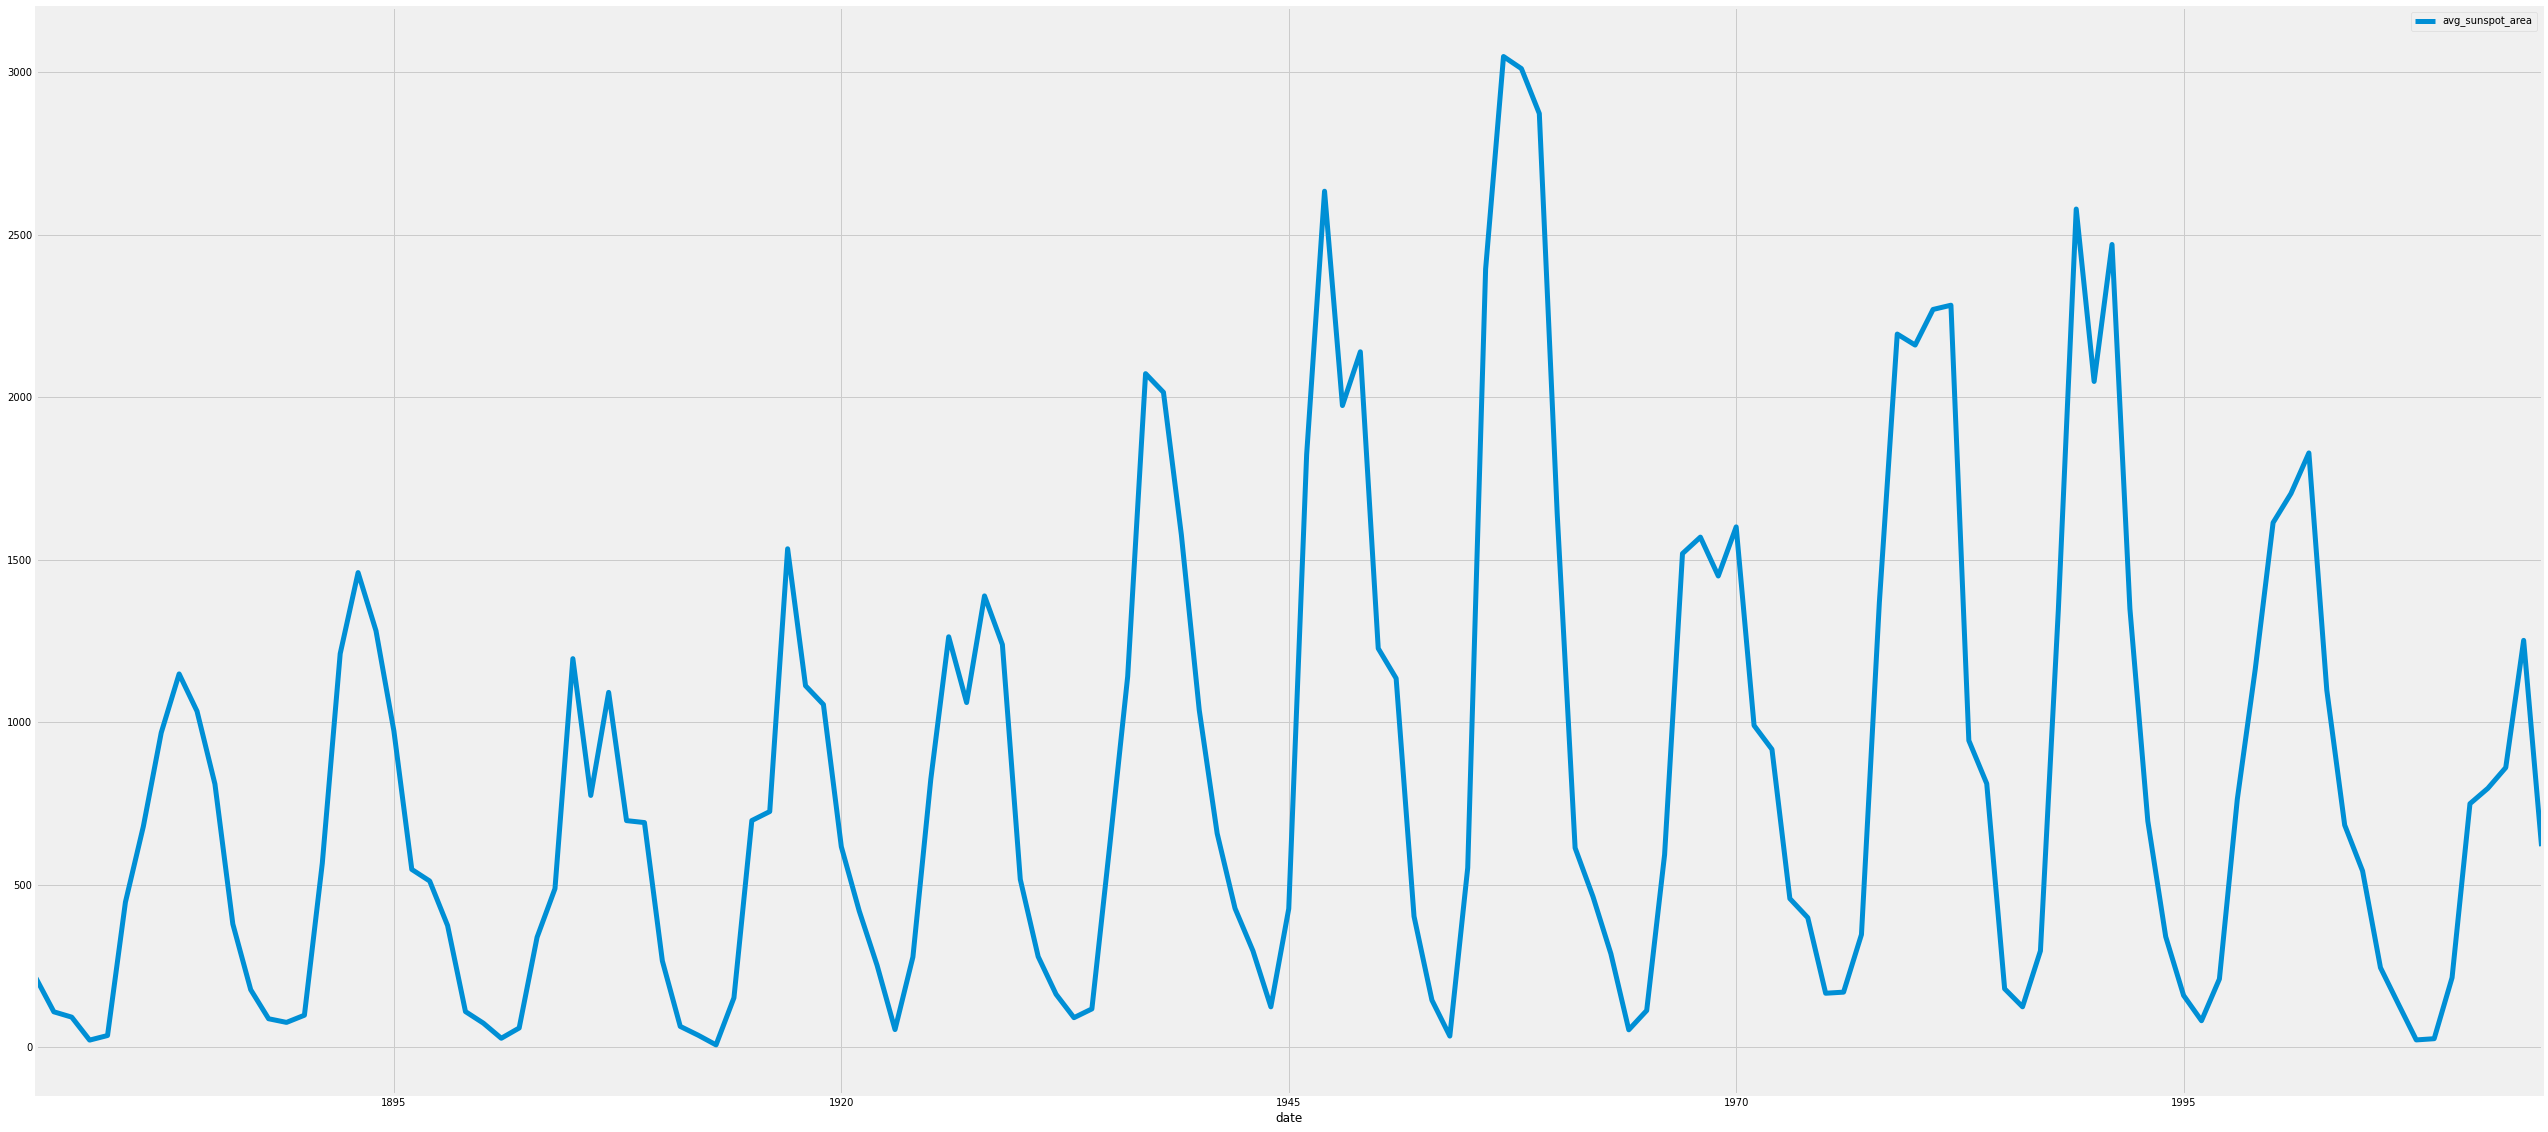

In [20]:

series = pd.read_csv(CFG.data_folder + 'sunspots.csv')
series['date'] = pd.to_datetime(series['date'])
series.set_index('date').plot()


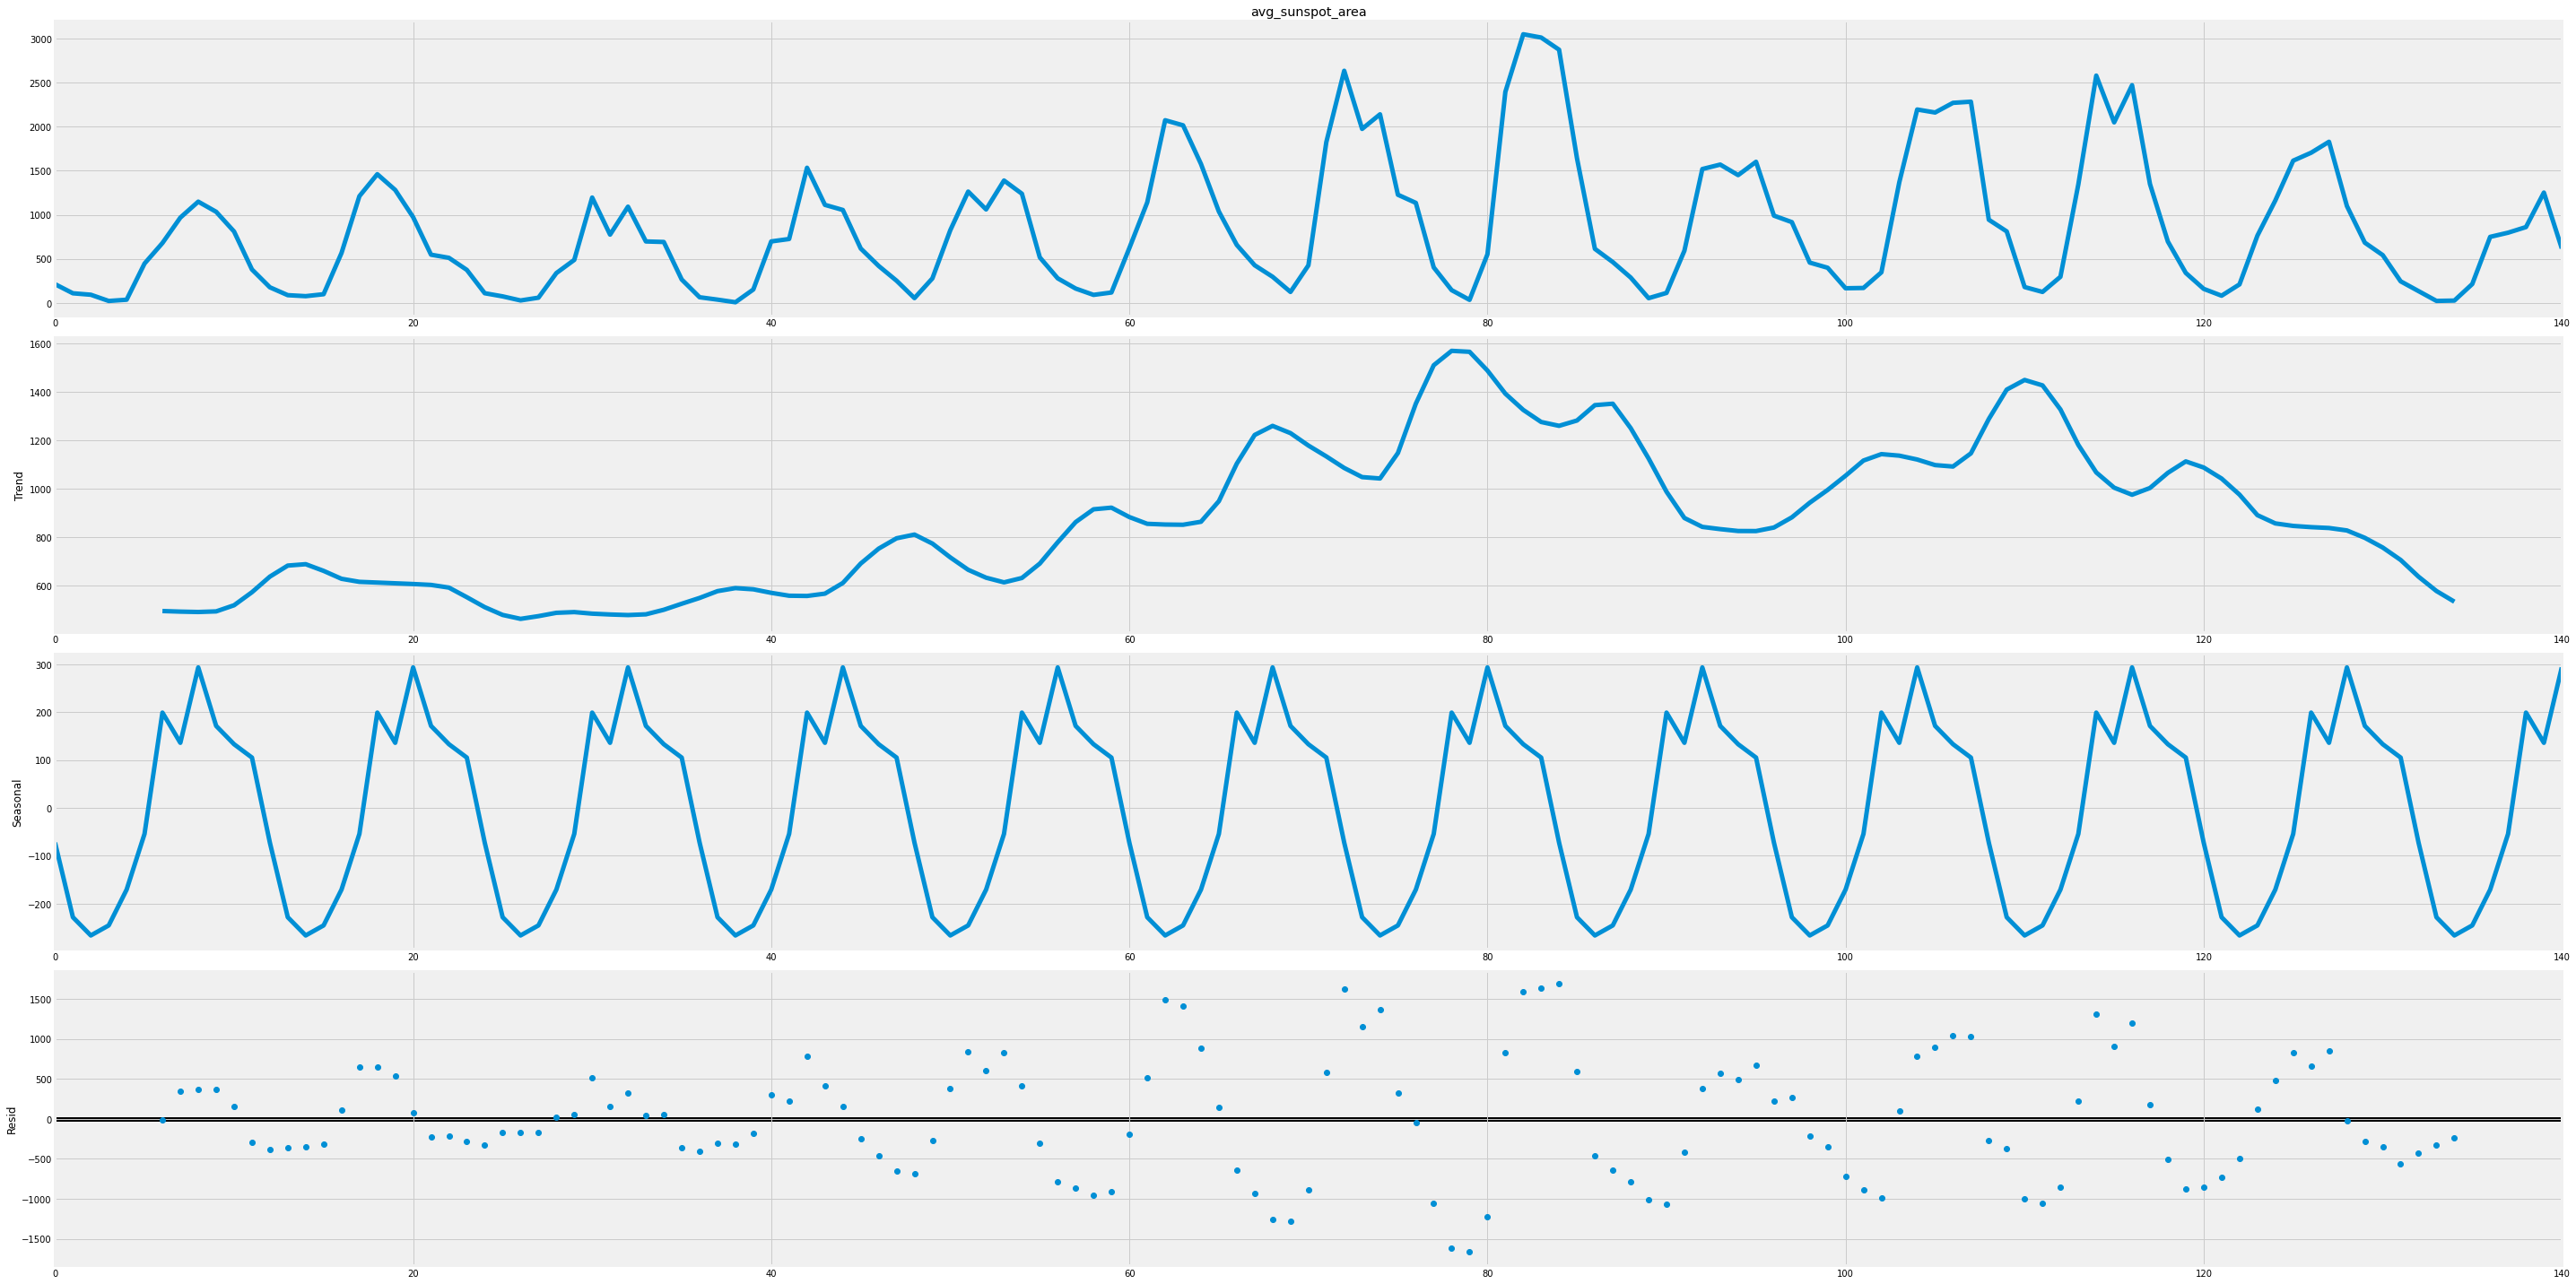

In [21]:
decomposition = sm.tsa.seasonal_decompose(series["avg_sunspot_area"],period =12) 
figure = decomposition.plot()
plt.show()

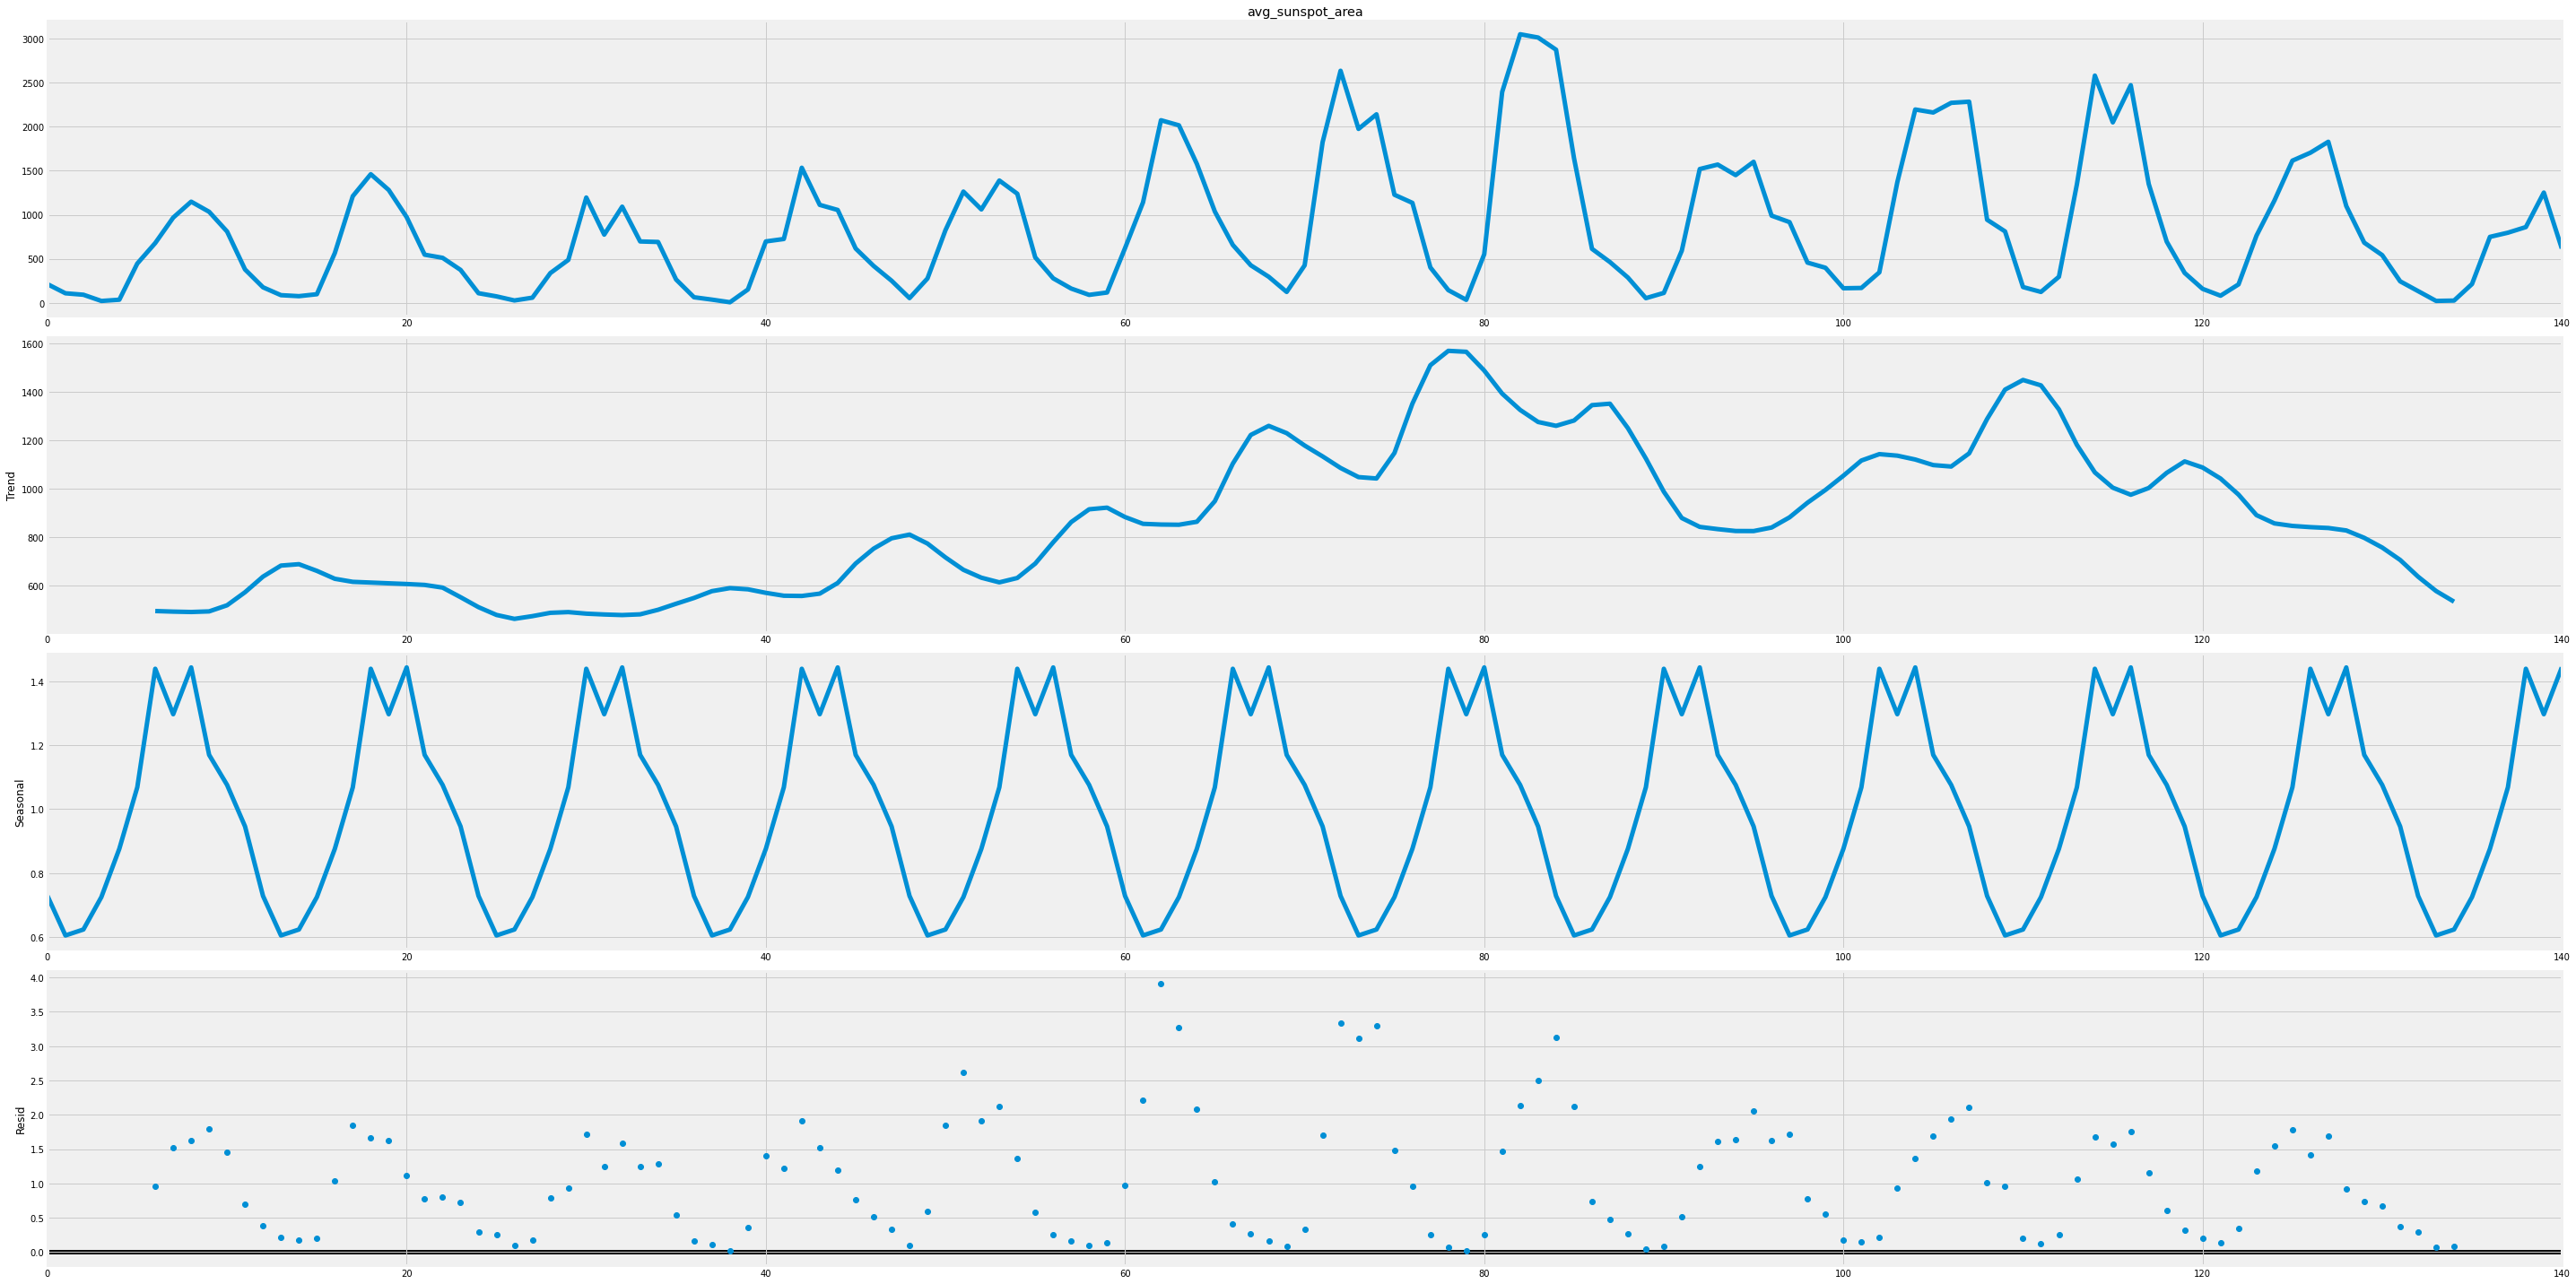

In [22]:
decomposition = sm.tsa.seasonal_decompose(series["avg_sunspot_area"],period =12, model = 'multiplicative') 
figure = decomposition.plot()
plt.show()

As we can see, changing the decomposition type to multiplicative alleviates the problem with residual behavior, but only to a certain degree - the pattern is still not consistent, with increase in the amplitude in the middle of the sample. This demonstrates that while seasonal decomposition is a fast tool, it has severe limitations when dealing with more sophisticated data generating processes.

<a id="section-three"></a>
# Dependence

The only way to succesful prediction is if past values of a series carry some information about the future behavior - in other words, if the present values are dependent on the past. A fast - and therefore very popular - manner of examining this dependence are the autocorrelation and partial autocorrelation functions, which are defined below:

Mean function of time series:
\begin{equation}
\mu_t = E [X_t]
\end{equation}

Autocovariance function of a time series:
\begin{equation}
\gamma(s,t) = Cov(X_s, X_t) = E [X_s X_t] - E[X_s]E[X_t]
\end{equation}

which leads to the following definitions of ACF / PACF:

Autocorrelation:
\begin{equation}
\rho(u,t+u) = Cor(X_{u}, X_{t+u}) = \frac{Cov(X_t, X_{t+u})}{Var(X_t) Var(X_{t+u})}
\end{equation}

Partial autocorrelation:
    \begin{equation}
    \phi(u) = Cor(X_t, X_{t+u}|X_{t+1}, \ldots , X_{t+u-1})
    \end{equation}

An intuitive way to think about it is that ACF at lag $k$ measures a linear dependence between $X_t$ and $X_{t+k}$, while PACF captures the dependence between those values **correcting** for all the intermediate effects. 

<a id="section-four"></a>
# Stationarity

In [23]:
import os
from IPython.display import Image
# Image(filename="../input/muh-images/gwozdzie.jpg", width= 600, height=200)


The reason why bother with the concept in stationarity can be is best summarized with a bad joke I heard many years ago as a math student: say, a mathematician is given a piece of wood with two nails - one hammered all the way in, the other half there - and told to get remove them. How does he solve it?
1. start with the nail that's completetely in - that's the more interesting case
2. once done, hammer the other all the way - to reduce to an already solved case

I warned you it was bad - but there is an analogy to how time series theory handles the problem of nonstationarity. 

To define things more formally, a stationary time series is one whose unconditional joint probability distribution does not change when shifted in time. This implies that parameters such as mean and variance also do not change over time.

Since stationarity is an assumption underlying many statistical procedures used in time series analysis, non-stationary data are often transformed to become stationary. A trend stationary process is not strictly stationary, but can easily be transformed into a stationary process by removing the underlying trend, which is solely a function of time; the same holds true for a stationary process with an added cyclical component. 

The core idea is that it's much easier to model dynamic behavior over time if the statistical properties do not change: oscillations happen around the same level, the amplitude does not change too much etc (in other words, the probability distribution of $X_t$ is the same as the distribution of $X_{t+h}$)- such models are well understood. Algorithms are likely to yield better predictions if we apply them to stationary processes, because we do not need to worry about e.g. concept drift between our training and test sets. 


If we are dealing with a process that does not adhere to those characteristics, we can either try and capture them directly or transform it in such a manner that it can be considered stationary. 

 
Below we plot a few examples of stationary and non-stationary series, starting with the simplest non-trivial stationary series: Gaussian white noise.

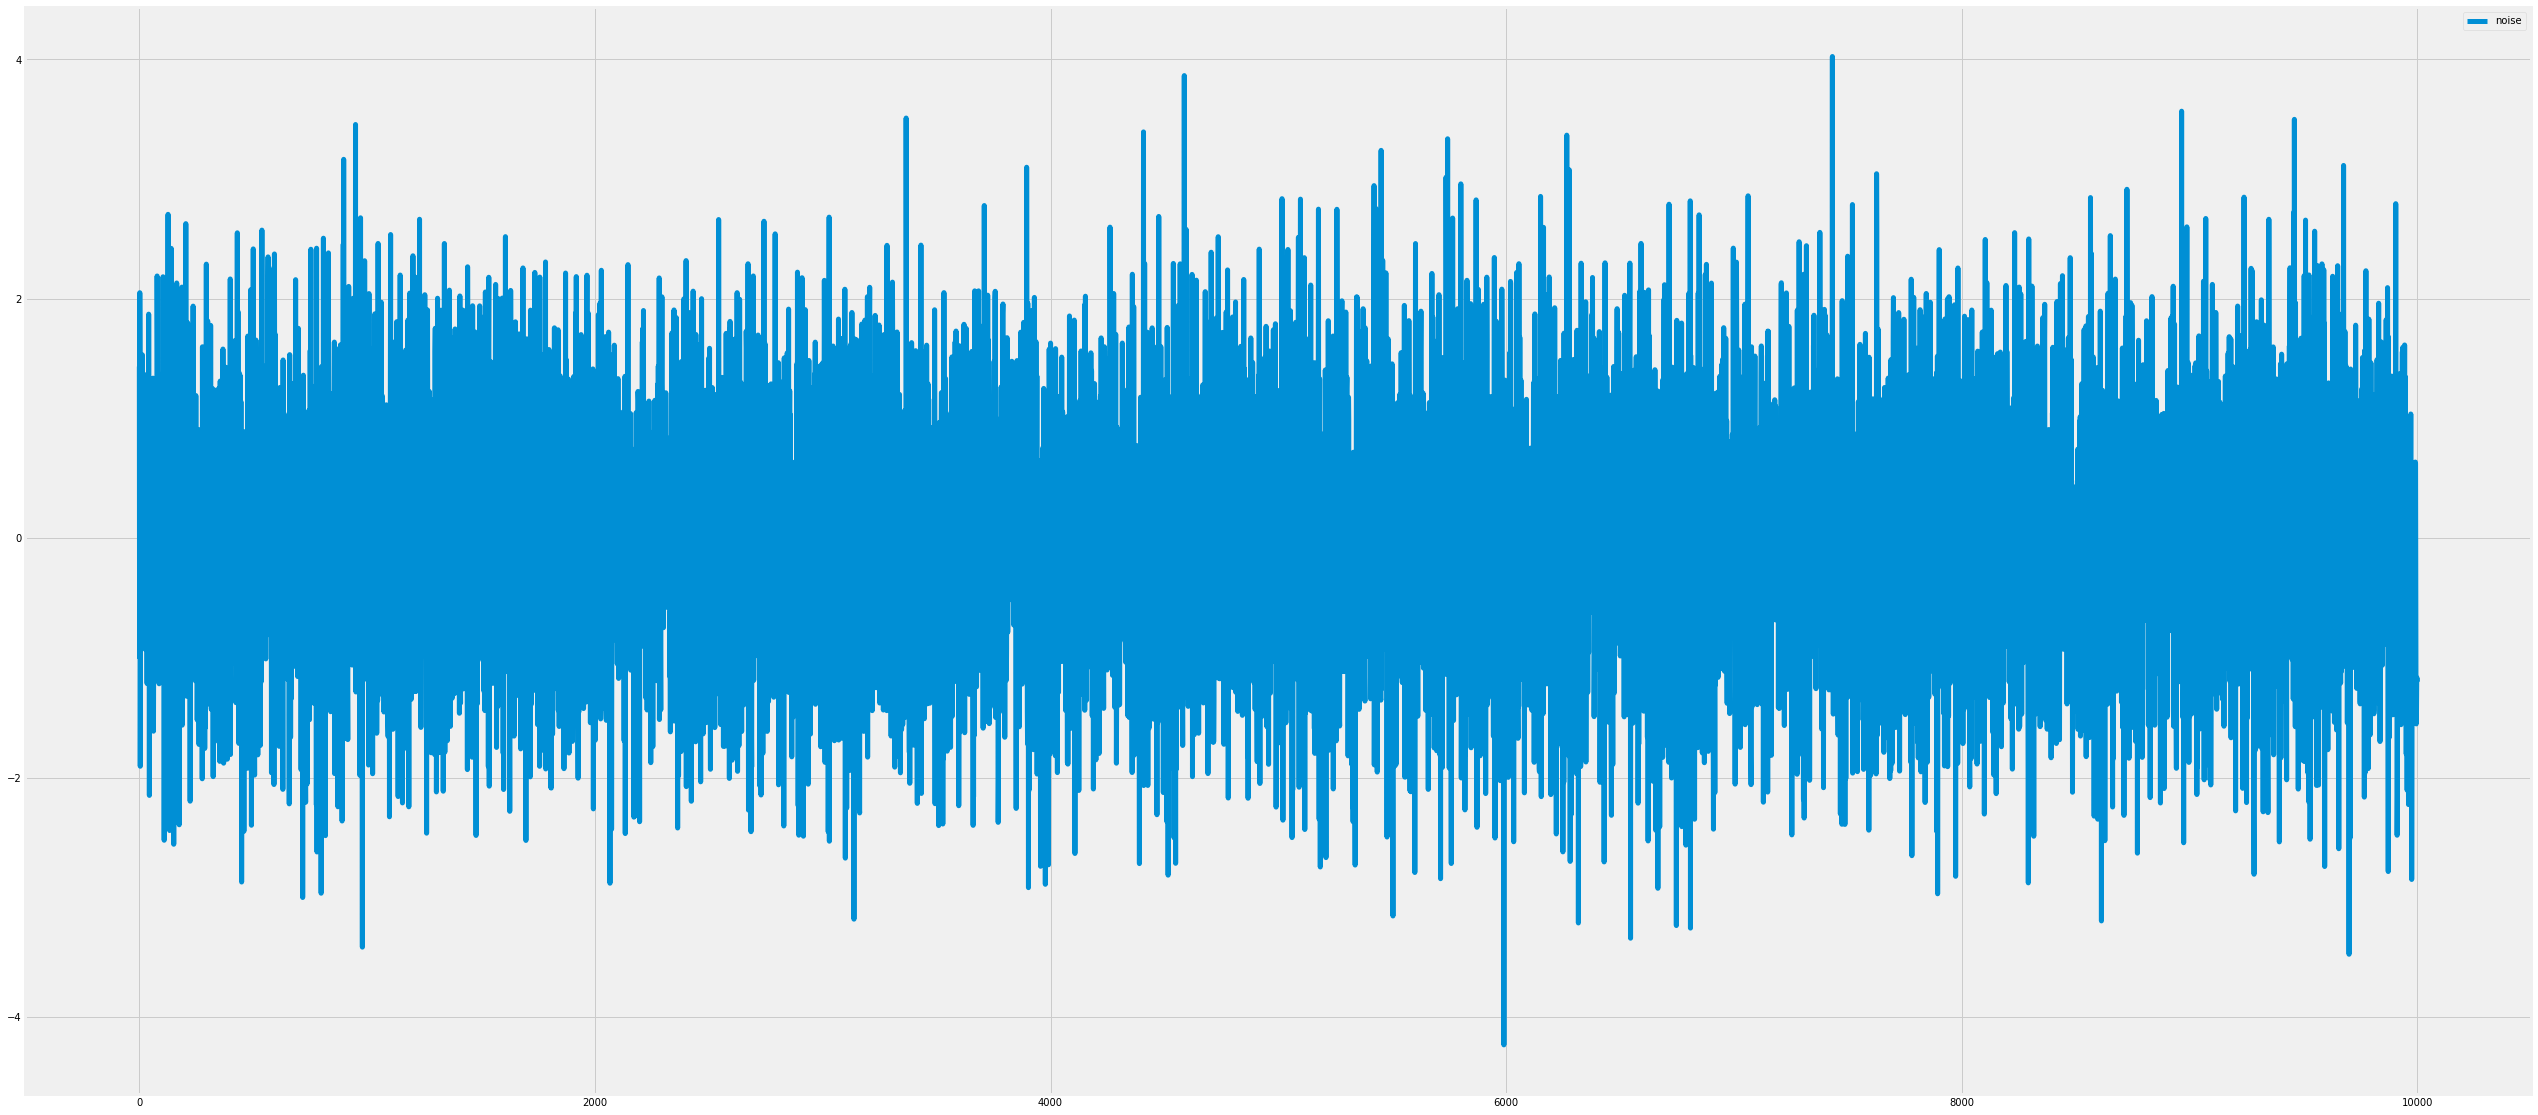

In [24]:
xseries = pd.DataFrame(data = np.random.normal(0, 1, 10000), columns = ['noise'] )
xseries.plot()
print()

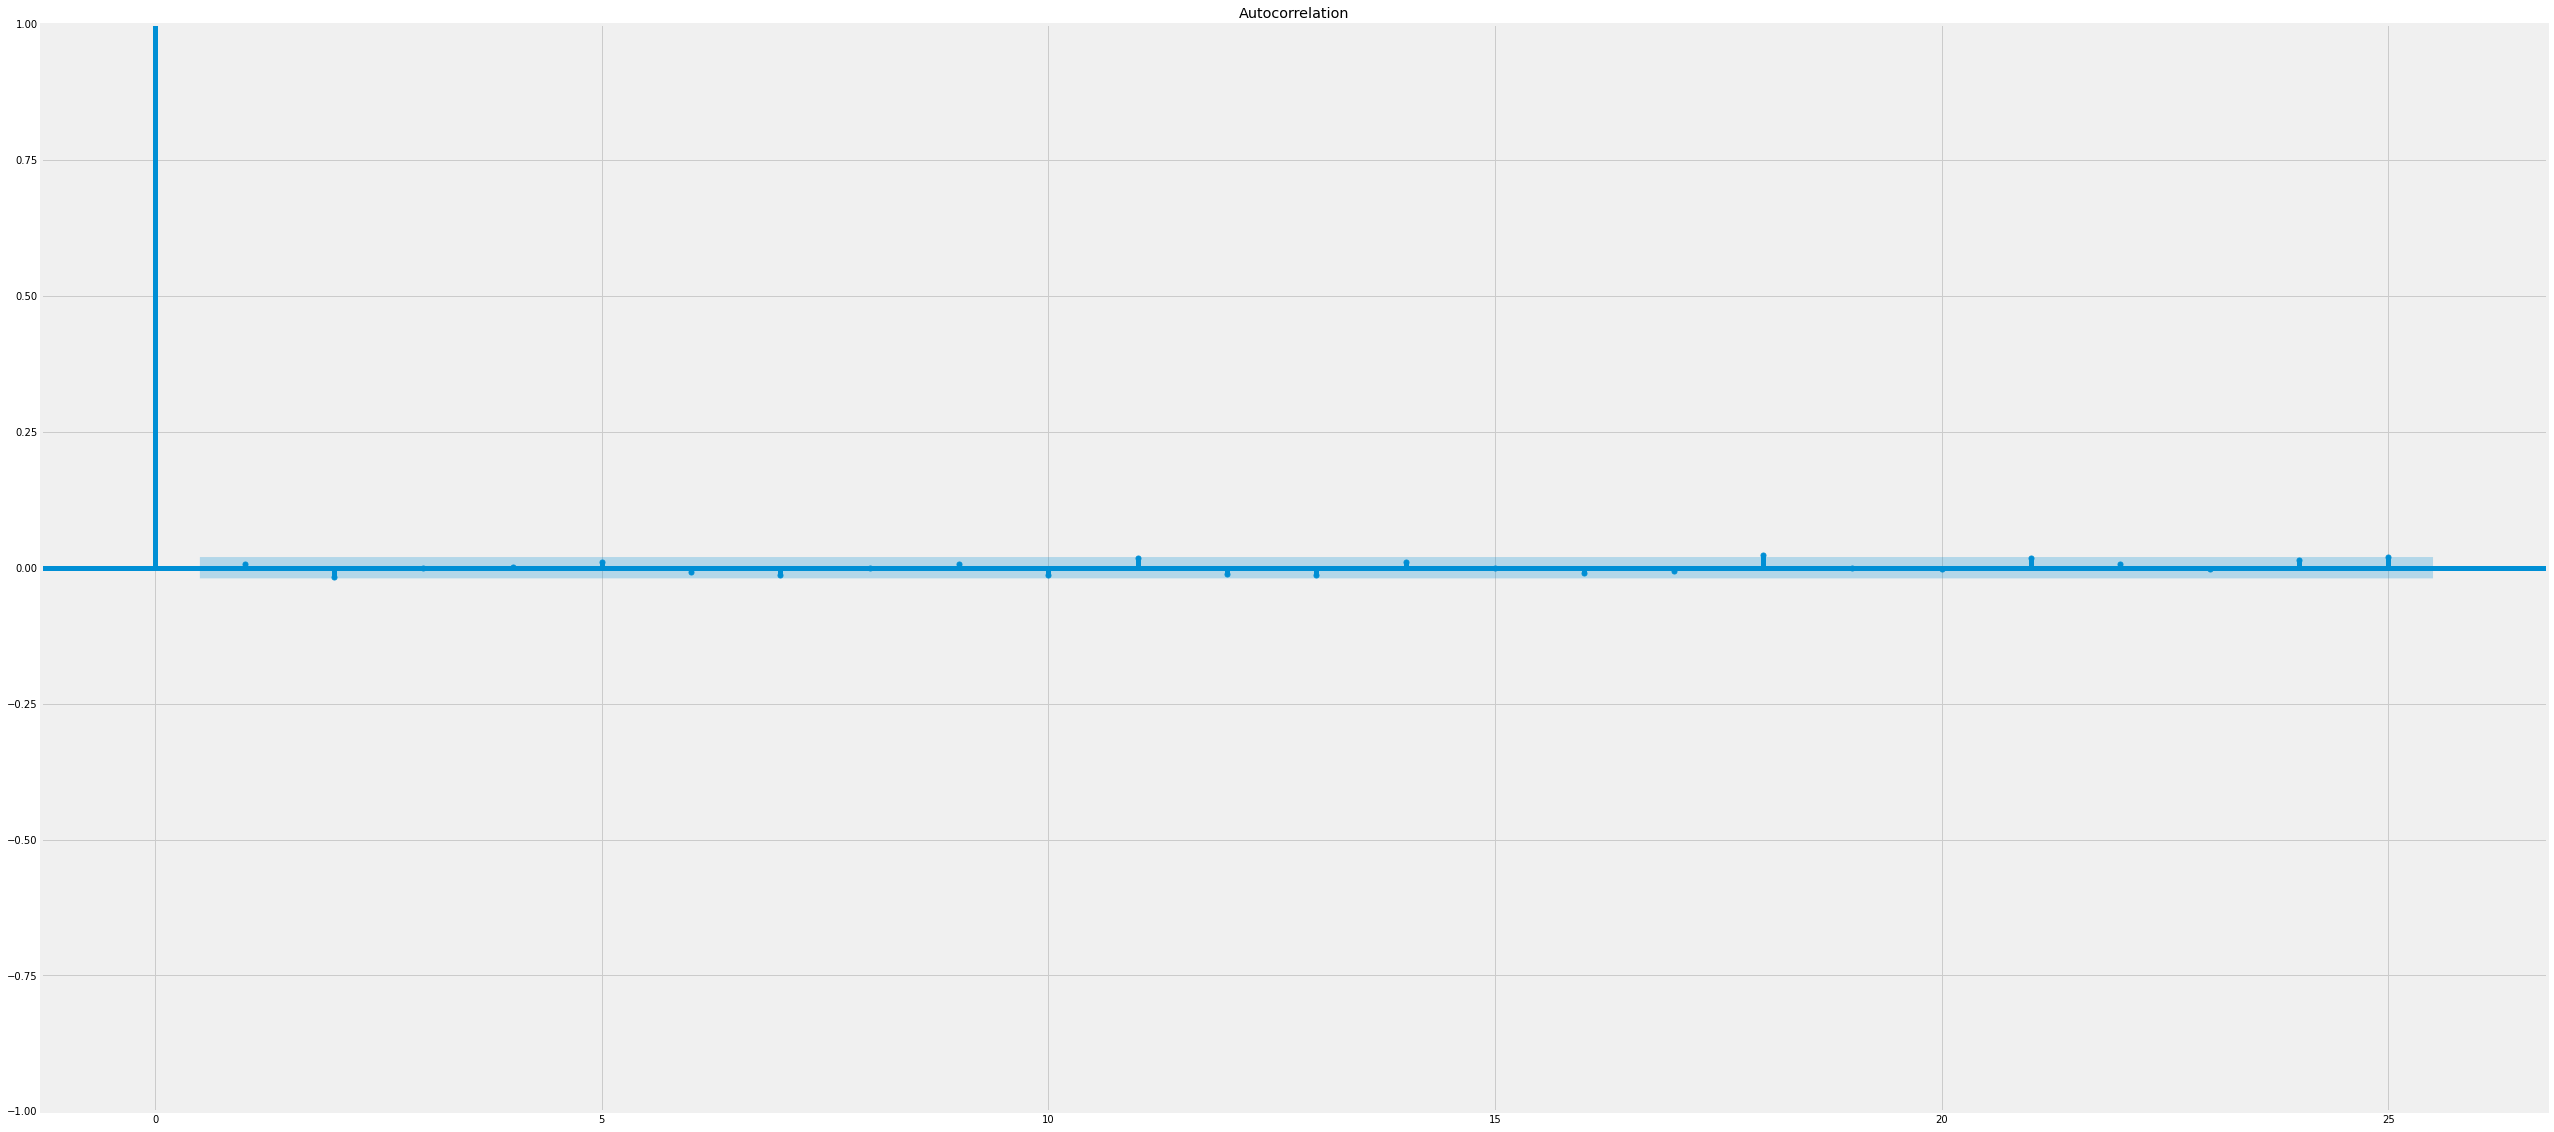

In [25]:
plot_acf(xseries['noise'], lags = 25)
print()

C:\Users\val-wd\AppData\Roaming\Python\Python39\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


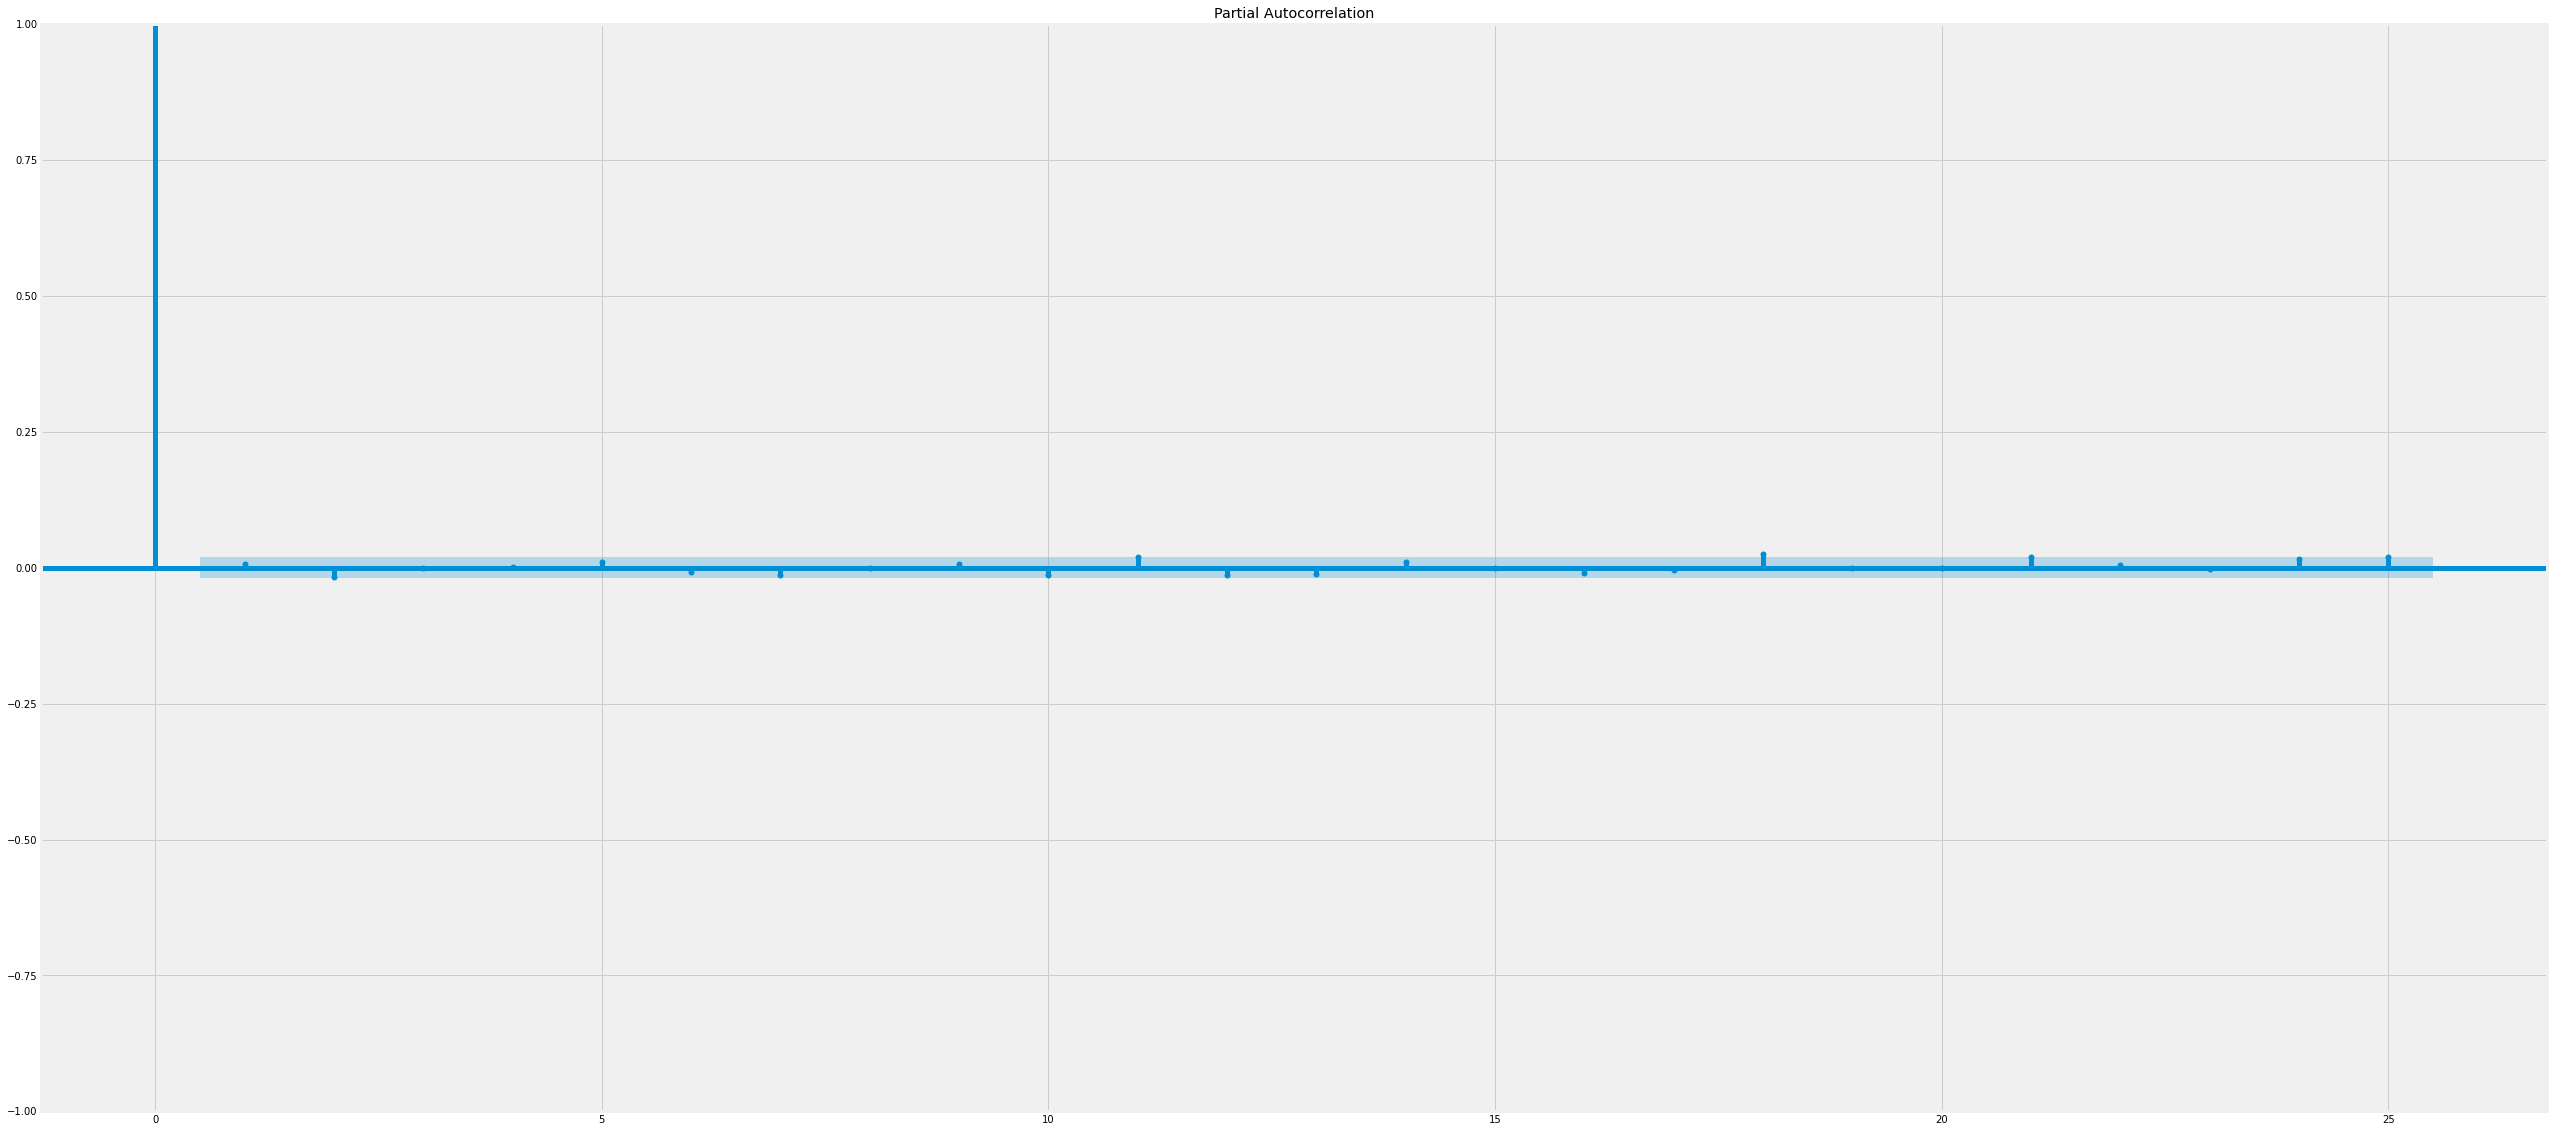

In [26]:
plot_pacf(xseries['noise'], lags = 25)
print()

For a slightly more interesting example (of non-stationary behavior), we can examine the passengers dataset:

<AxesSubplot:xlabel='date'>

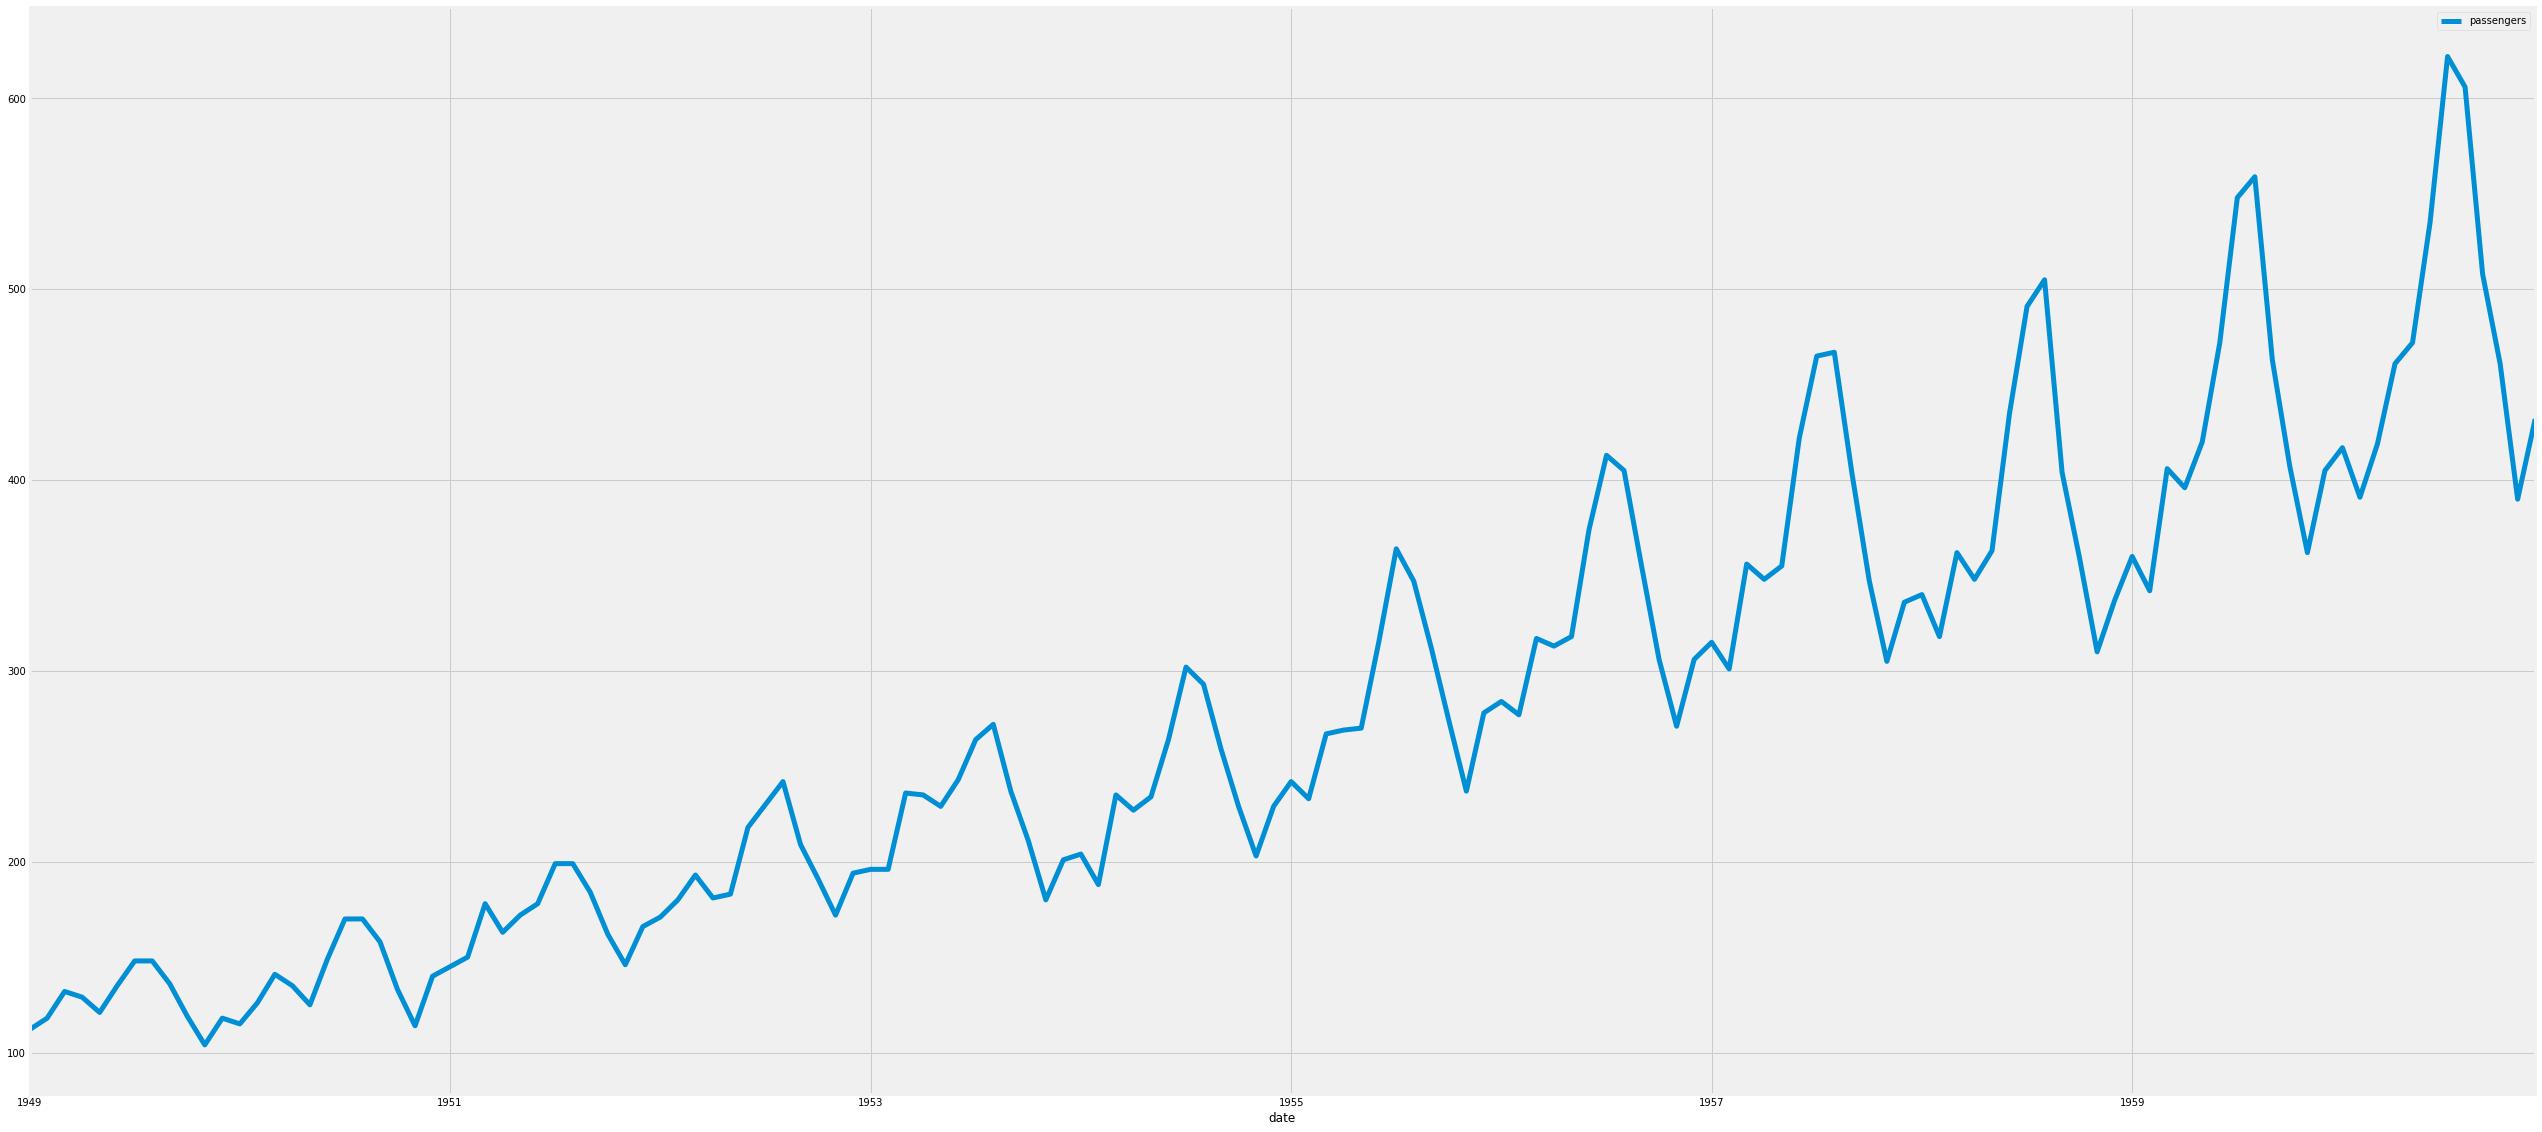

In [27]:
# Non-stationary example
series = pd.read_csv(CFG.data_folder + 'passengers.csv')
series['date'] = pd.to_datetime(series['date'])
series.set_index('date').plot()

The stationarity of a series can be checked by examining the distribution of the series: we split the series into 2 contiguous parts and compute the summary statistics like the mean, variance and the autocorrelation. If the stats are quite different, then the series is not likely to be stationary.

<AxesSubplot:ylabel='Frequency'>

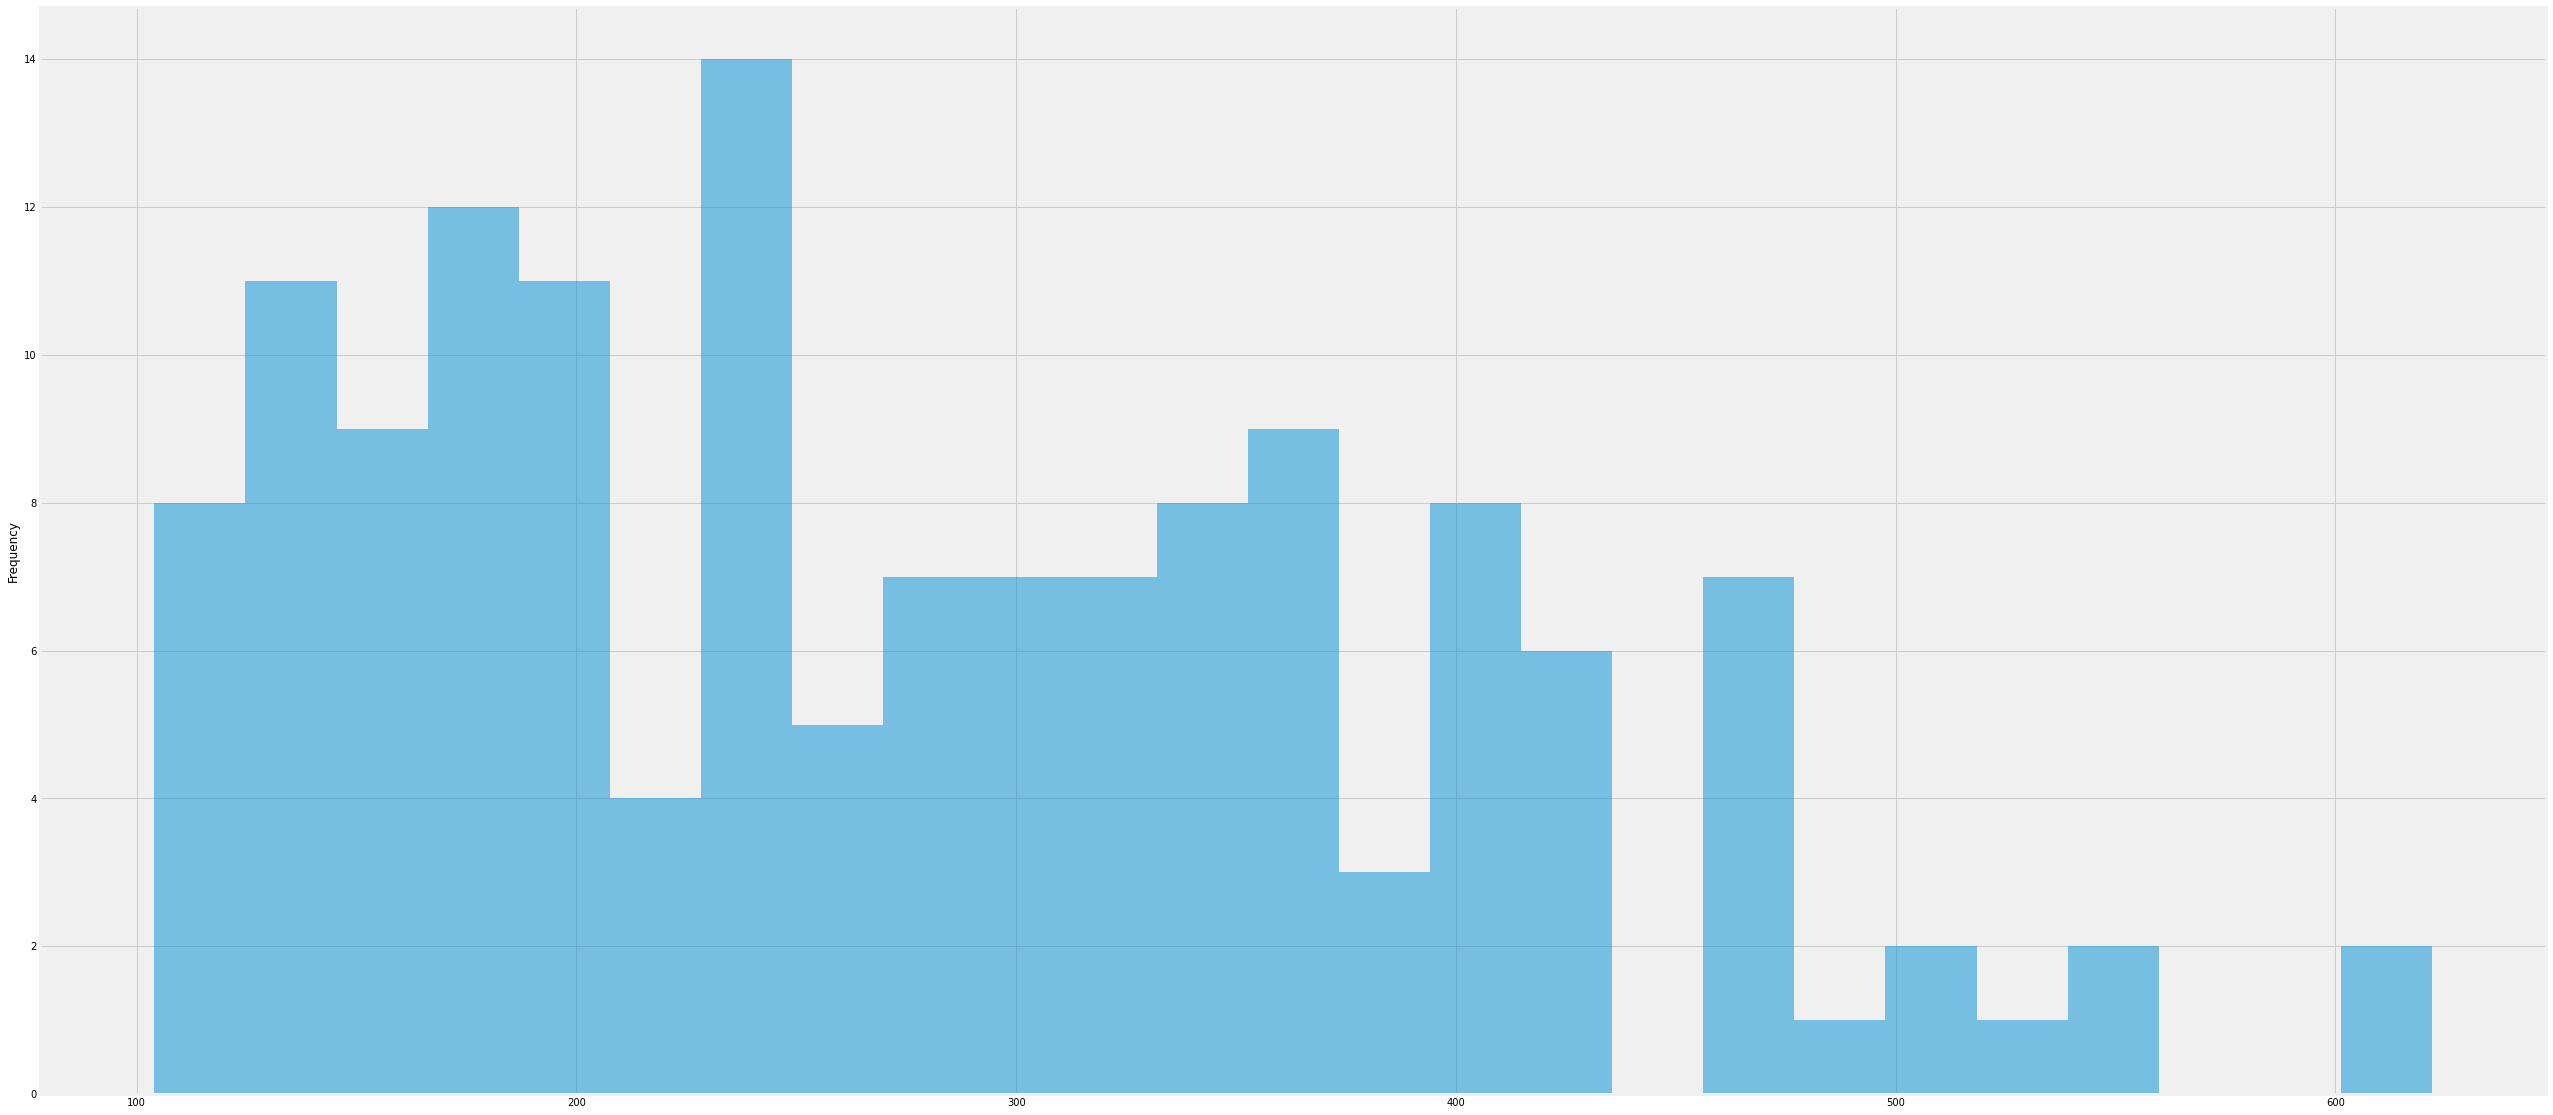

In [28]:
series = pd.read_csv(CFG.data_folder + 'passengers.csv')
series['date'] = pd.to_datetime(series['date'])
# series.set_index('date').plot()

series['passengers'].plot.hist(bins=25, alpha=0.5)


Compute the summary statistics:

In [29]:
X = series.passengers.values
split =  int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean:')
print('chunk1: %.2f vs chunk2: %.2f' % (mean1, mean2))
print('variance:')
print('chunk1: %.2f vs chunk2: %.2f' % (var1, var2))


mean:
chunk1: 182.90 vs chunk2: 377.69
variance:
chunk1: 2244.09 vs chunk2: 7367.96


The values are clearly very different across the two data subsets, which strongly suggests non-stationarity. However, visual inspection is not what one would could a rigorous criterion - so let's define things in a formal manner.

## (A little bit of) theory

Given a stochastic process $\{X_t\}$ and cdf $F_X$, a process is strictly stationary iff 

\begin{equation}
F_X(X_{t_1}, \ldots, X_{t_n}) = F_X(X_{t_1 + \tau}, \ldots, X_{t_n + \tau})
\end{equation}

The definition is very powerful (if we know a cdf of a distribution, we can infer everything) - however, it is not possible to verify in practice. For that reason, a less strict variant has been introduced: weak a.k.a. second order stationarity:

a process $\{X_t\}$ is weakly stationary if it satisfies the following conditions:

* $\mu_t = \mu_{t + \tau}$
* $\gamma(s,t) = \gamma(s-t)$
* $Var(X_t) < \infty$

Implication:
* constant mean
* covariance only depends on distance in time between variables
* autocorrelation:
    \begin{equation}
    \rho(u) = \frac{\gamma(u)}{\gamma(0)}
    \end{equation}
    
    
So how can we turn a non-stationary series into a stationary one? Popular transformations include (but are not limited to!): 
* differencing the series 
* taking the log of the series
* power transforms 


### Differencing

* Lag operator of order $d$:

\begin{equation}
\nabla_d X_t = X_t - X_{t-d}
\end{equation}
    
Differencing can help stabilize the mean of a time series by removing changes in the level of a time series, and so eliminating trend and seasonality. Differencing at lag 1 is best thought of as discreet counterpart to differentiation: first derivative of a linear function is flat, first derivative of a quadratic function is linear etc - so if we want to get rid of a trend behaving like polynomial of degree $n$, we need to apply the differencing operator $n$ times. 


It is important to understand the difference between iterating diffencing operator $n$ times and differencing once at lag $n$ - which is best demonstrated in an example. 

### Tests for stationarity

While inspecting plots before / after transformation can be useful to assess presence of trends or seasonalities (as we did above with the passengers dataset), in practice we need a more formal approach - like testing a hypothesis (introduction to statistical tests is beyond the scope of this notebook, so if you feel like you need a refresher, please consult other sources). The most popular tests dealing with stationarity are: 

* Augmented Dickey-Fuller (ADF))
* Kwiatkowski–Phillips–Schmidt–Shin (KPSS)
* Philips-Perron (PP)


ADF test is a unit root test.  It determines how strongly a time series is defined by a trend. 
-  Null Hypothesis (H0): Null hypothesis of the test is that the time series can be represented by a unit root that is not stationary.
- Alternative Hypothesis (H1): Alternative Hypothesis of the test is that the time series is stationary.

Interpretation of p value:
- above $\alpha$: Accepts the Null Hypothesis (H0), the data has a unit root and is non-stationary.
- below $\alpha$ : Rejects the Null Hypothesis (H0), the data is stationary.



ACF / PACF

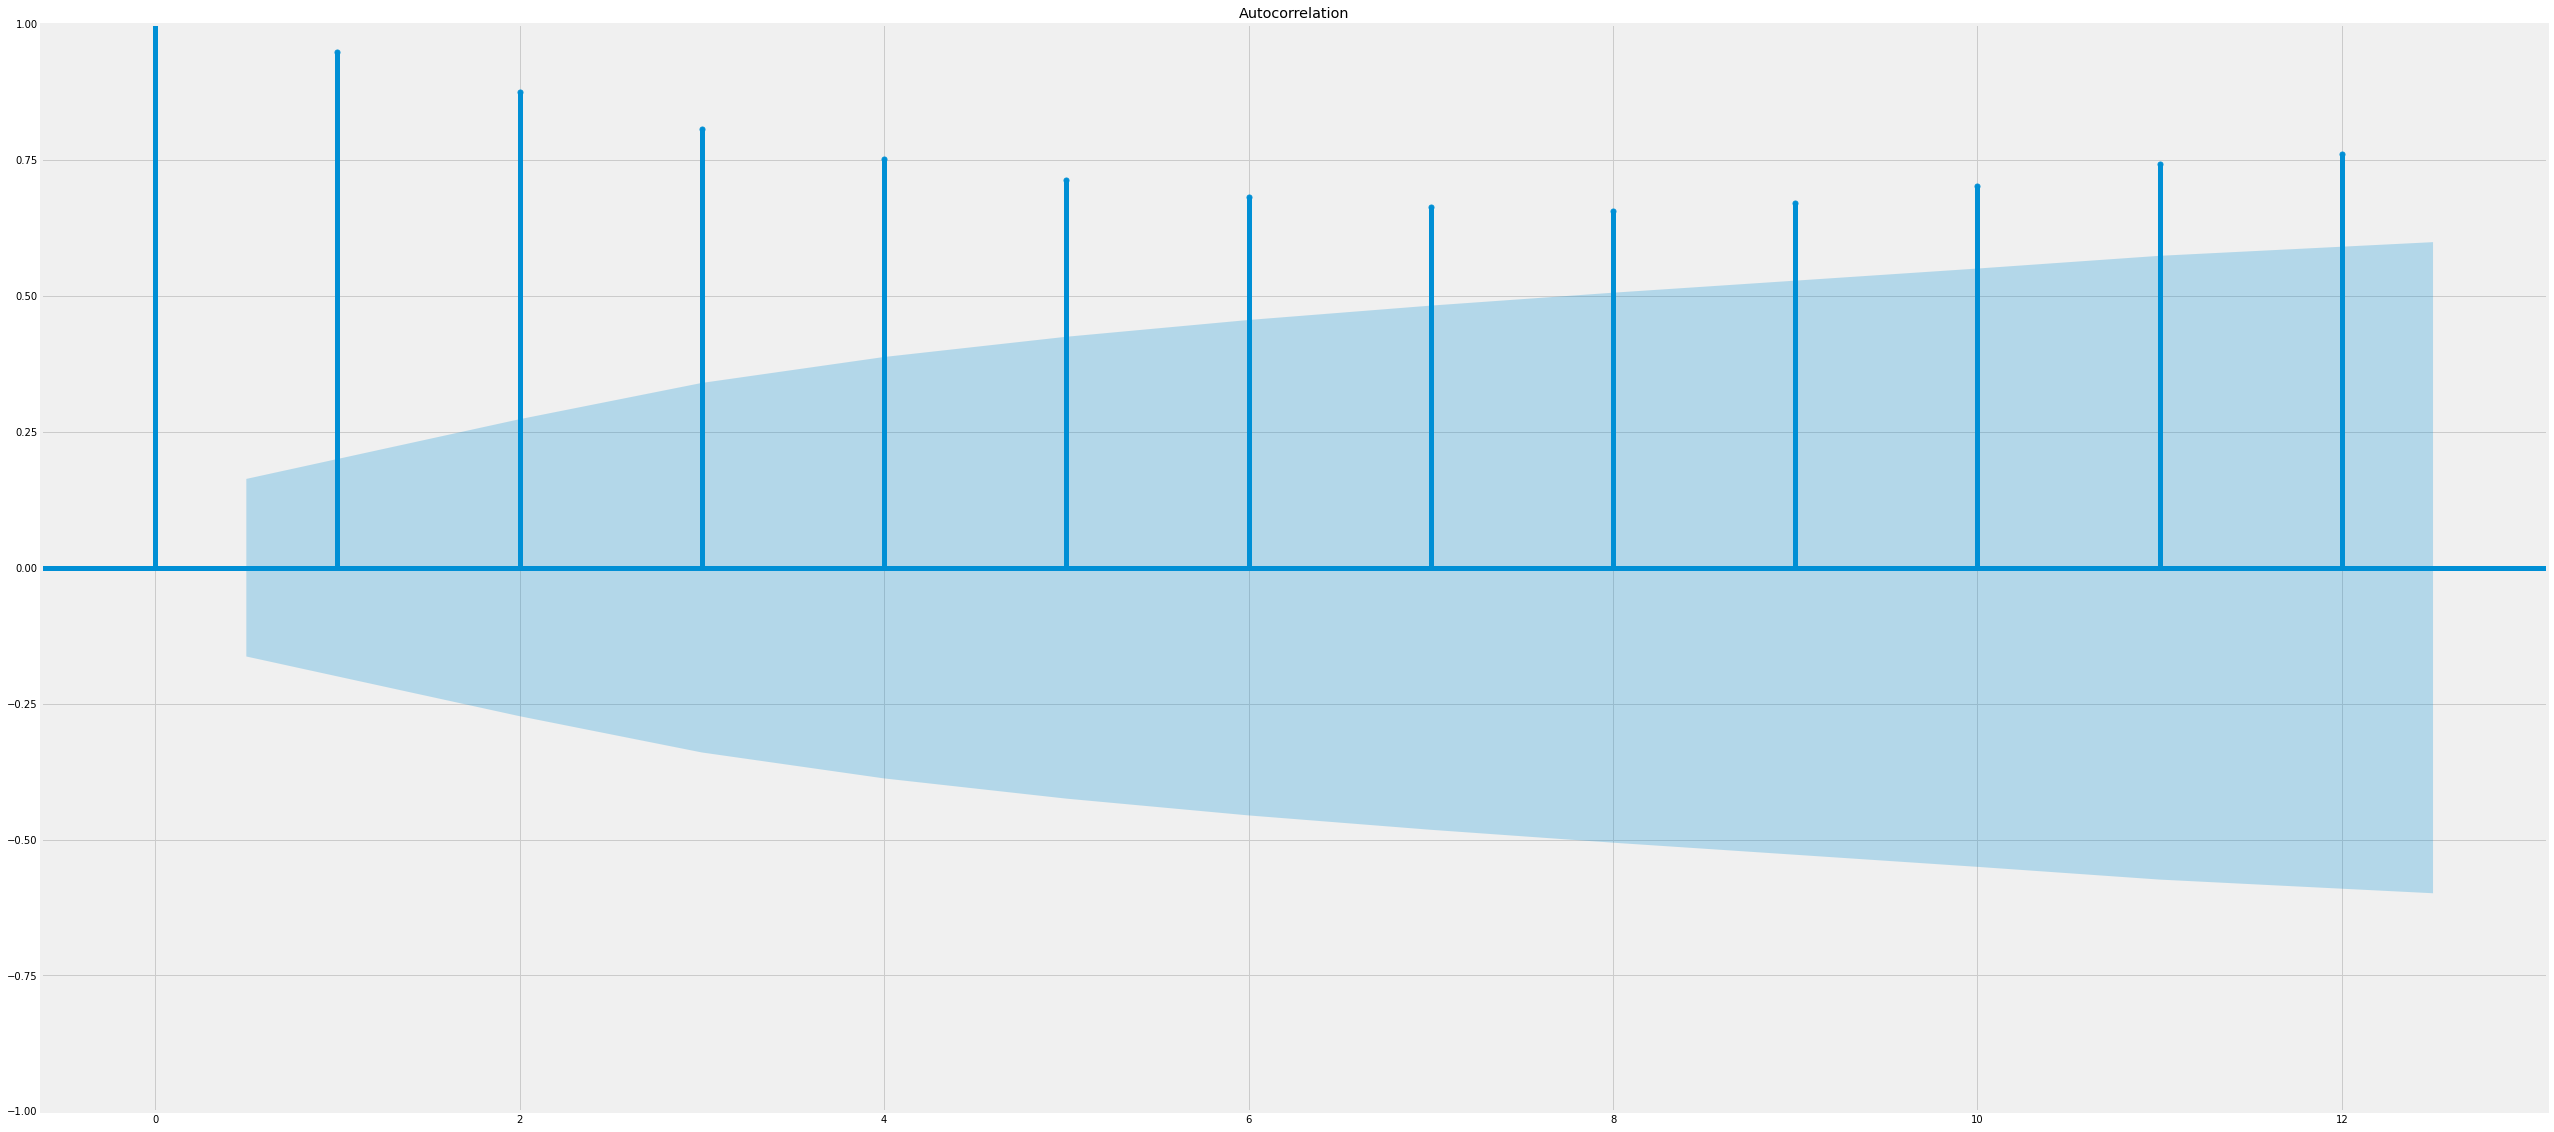

In [30]:
plot_acf(X, lags = 12)
plt.show()

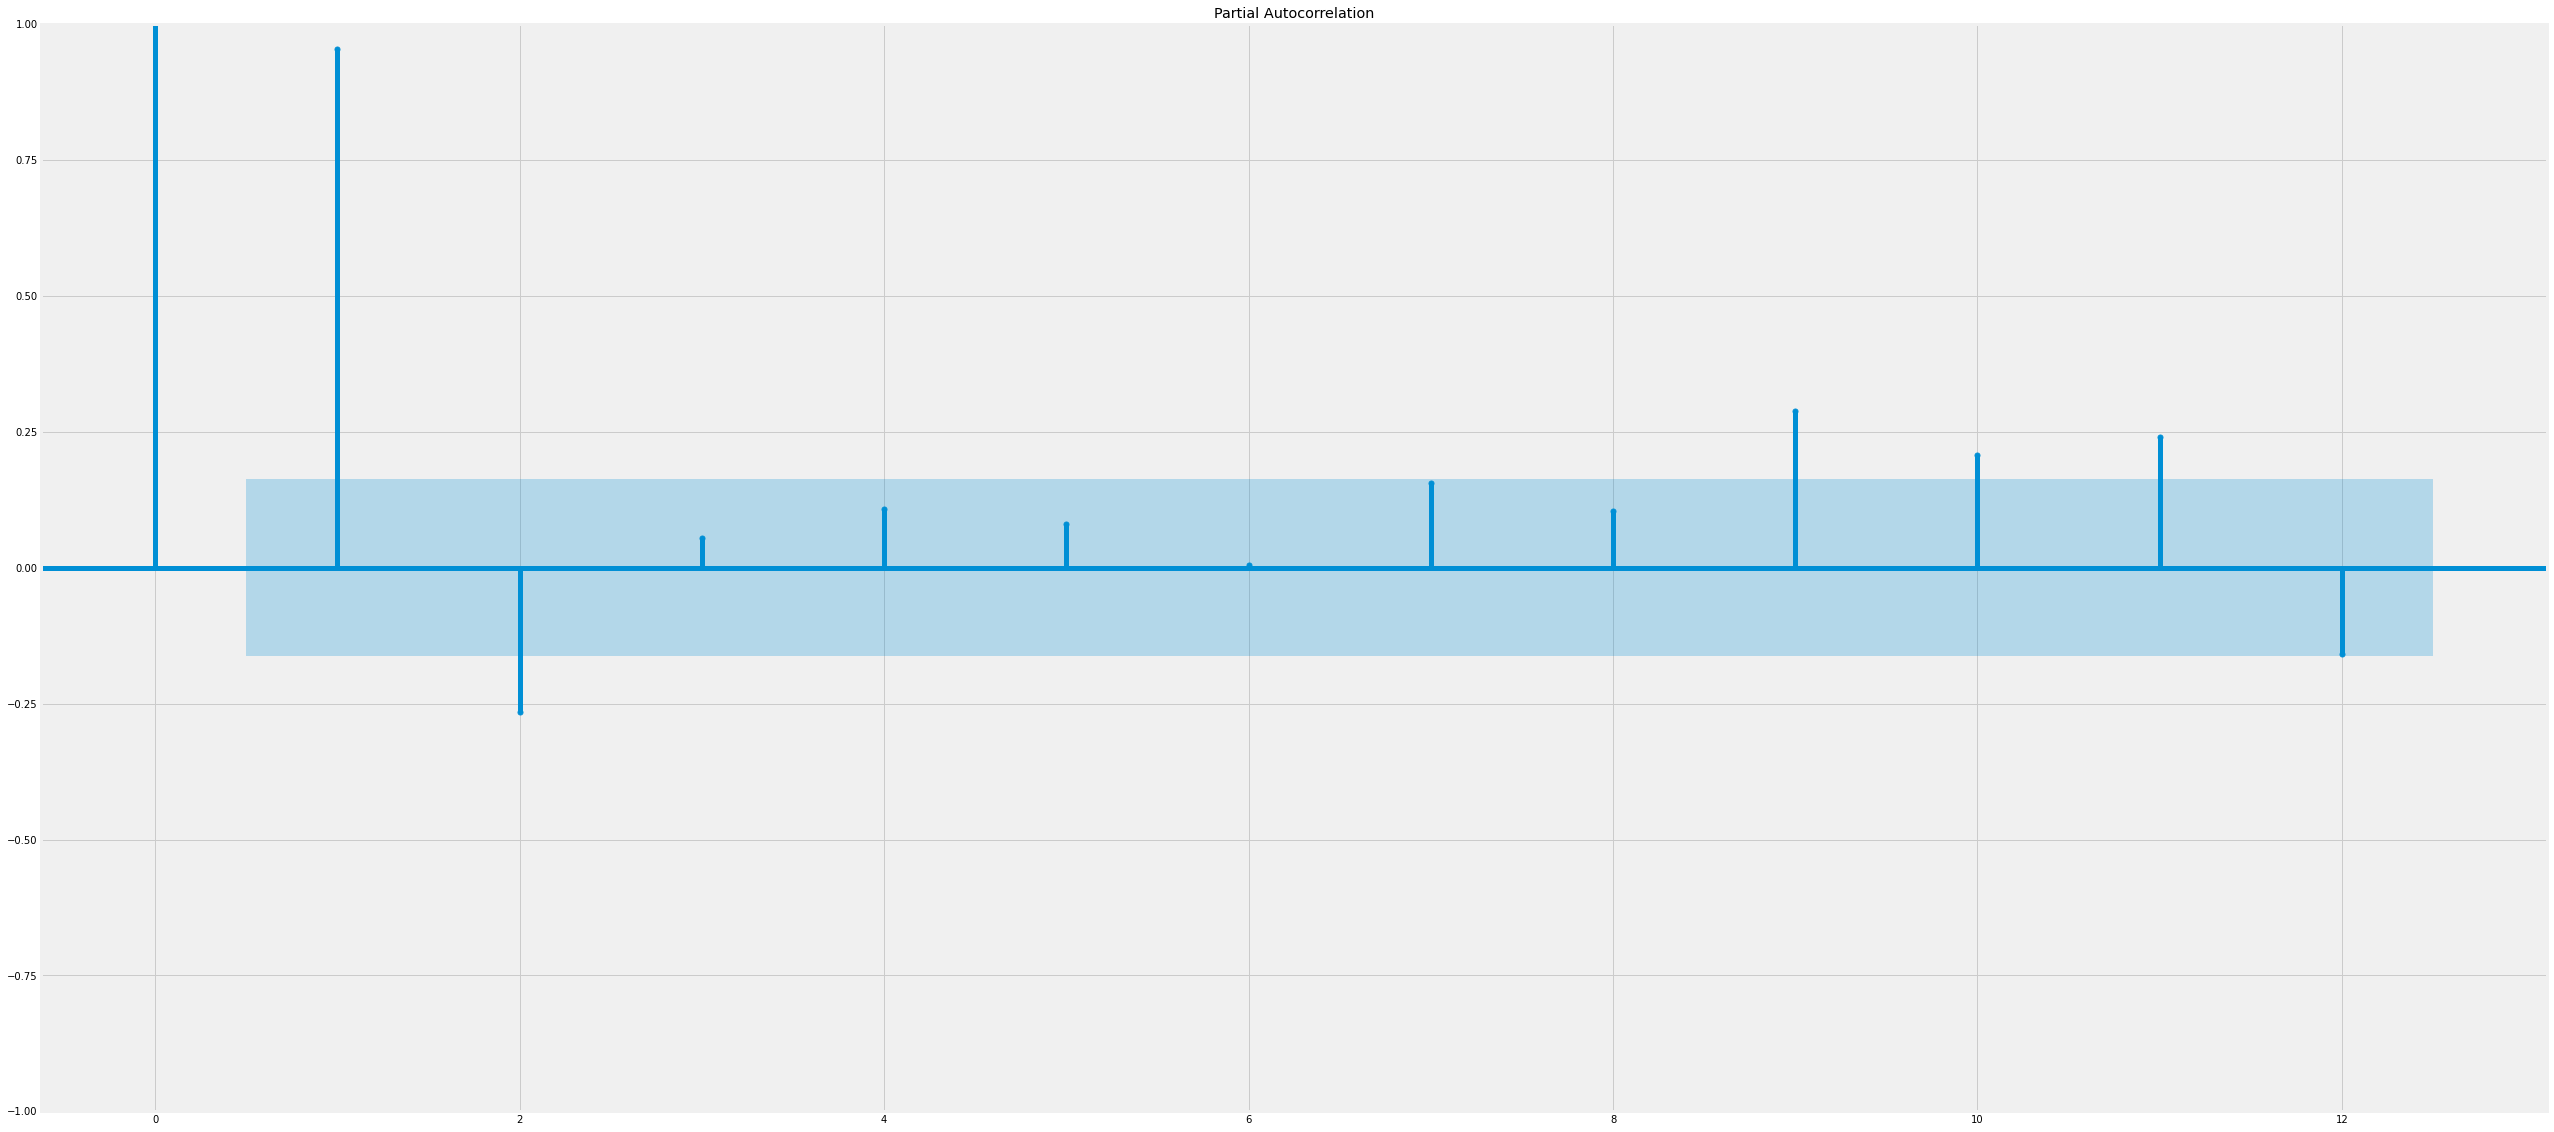

In [31]:
plot_pacf(X, lags = 12)
plt.show()

We can decompose the series to check the components one by one: which parts are responsible for the non-stationary behavior?

In [32]:
decomposition = seasonal_decompose(X, model='additive', period =12)

In [33]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


An important caveat: it is useful to remember that statistical tests do not **accept** a hypothesis - we can only fail to reject it. 

In [34]:
# skip the start of the series: adfuller does not handle missing values which appear for values within the first full period
result = adfuller(decomposition.trend[10:-10])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 1.025948
p-value: 0.994532


In [35]:
result = adfuller(decomposition.seasonal[10:-10])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -9803311645880354.000000
p-value: 0.000000


In [36]:
result = adfuller(decomposition.resid[10:-10])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -5.029170
p-value: 0.000019


As we can see, the hypothesis of non-stationarity is non rejected for the trend component, but not for seasonal. The reason for that is that ADF test check for a very specific form of non-stationarity, namely variation in the presence of a linear trend (existence of a single unit root) - while the seasonal component is clearly not stationary (see graph above), it is a qualitatively different kind of behavior.

Let's go back to our hammer-and-nail approach and try some transformations to make the series stationary.

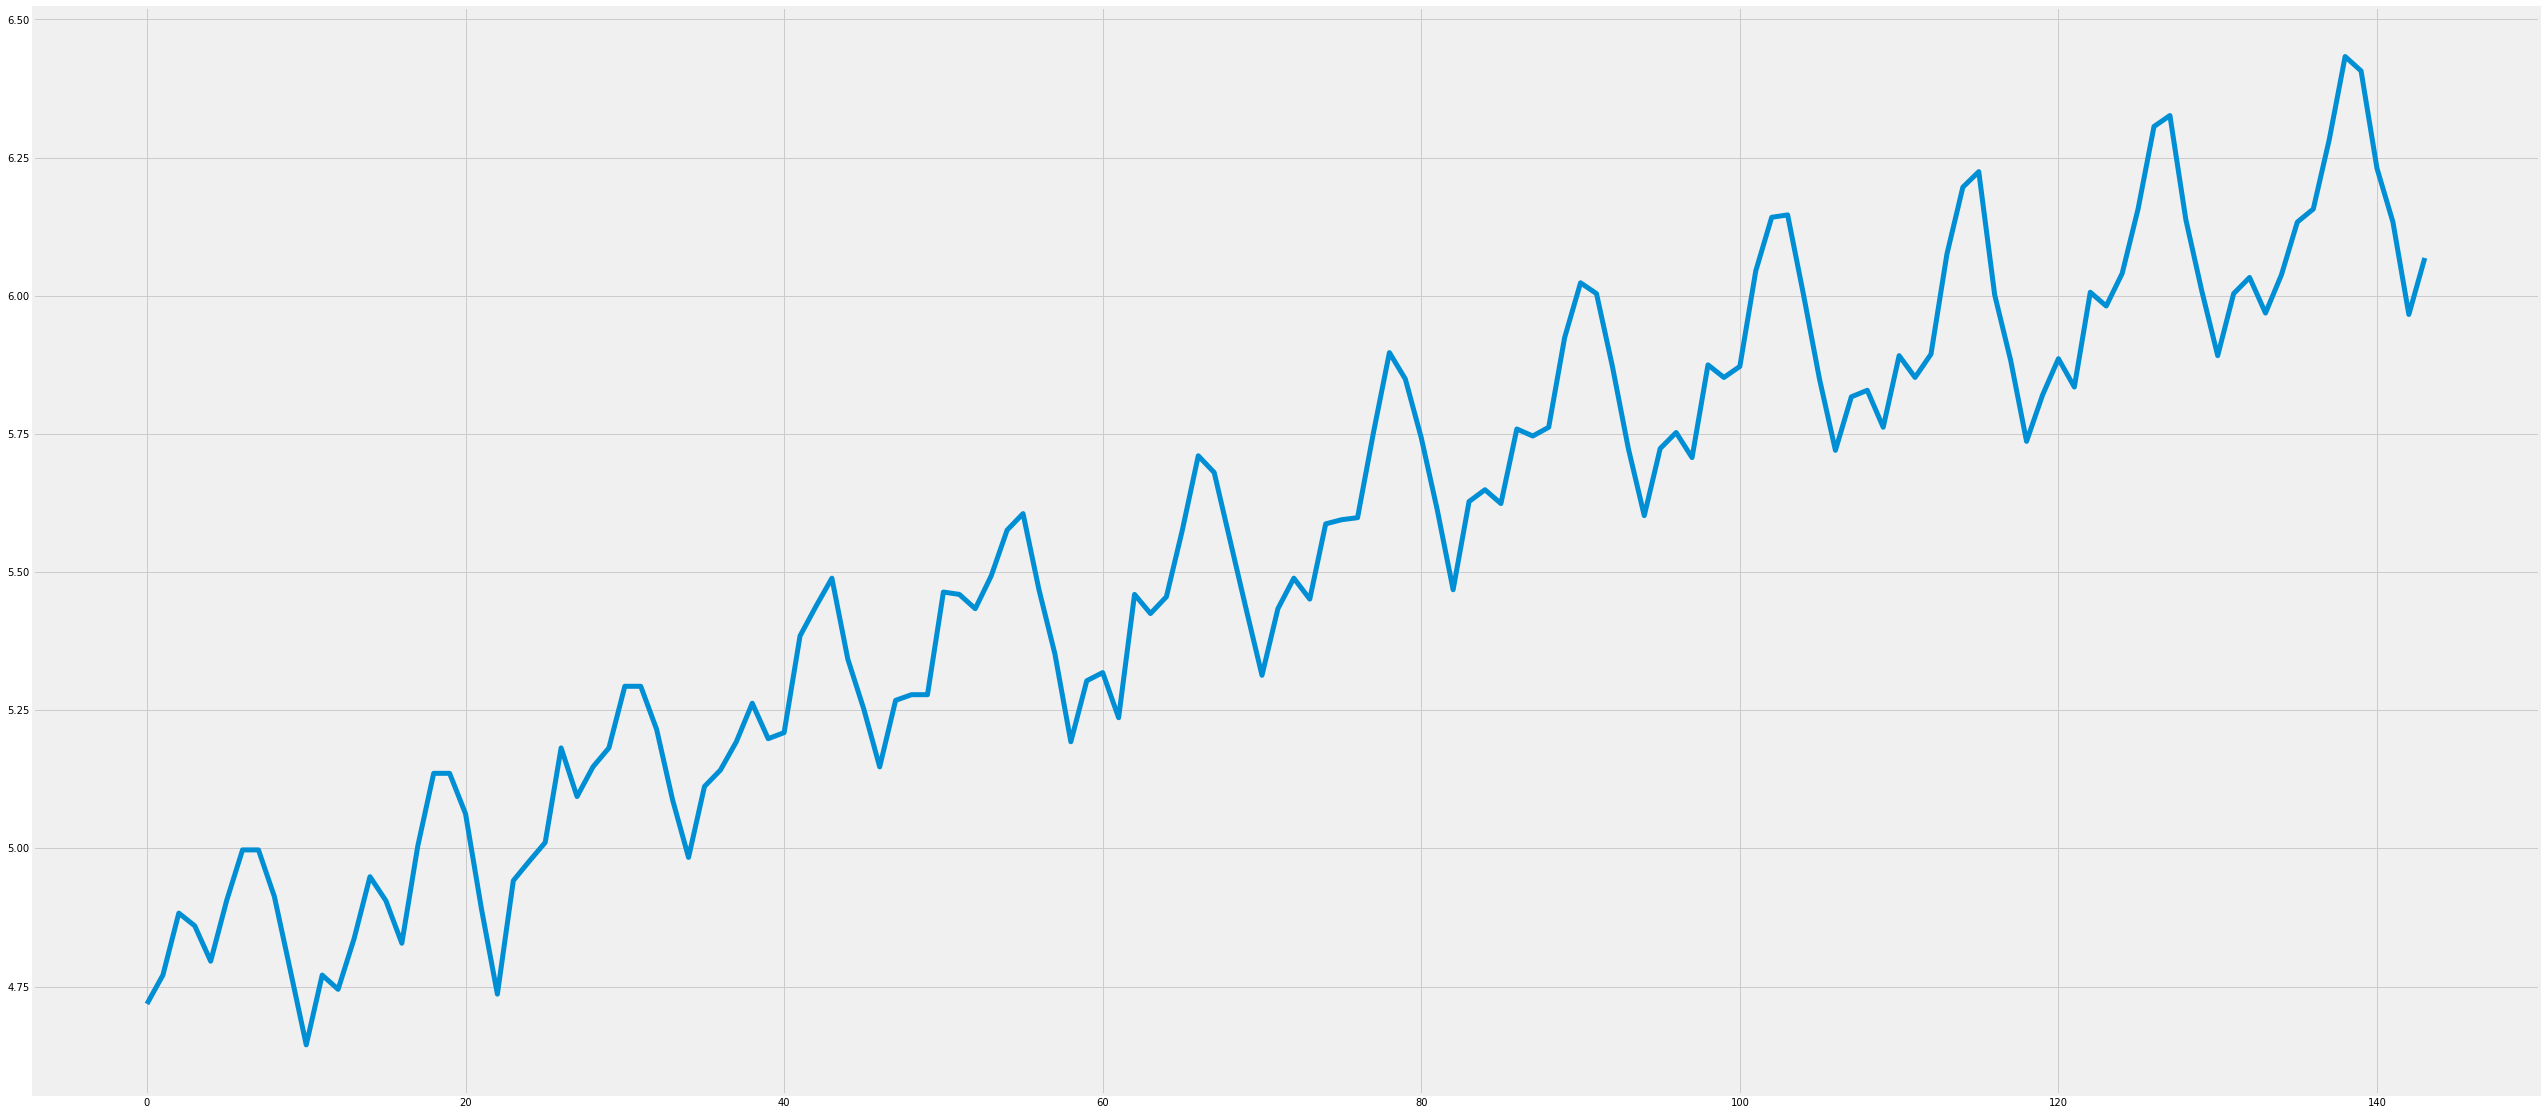

In [37]:
series['passengers2'] = np.log(series['passengers'])
series.passengers2.plot()
plt.show()

Applying a logarithm does not remove the trend, but it does seem to stabilize the amplitude (periodic variations have comparable magnitude now). How does that translate into ADF results?

In [38]:
result = adfuller(series.passengers2)
print('p-value: %f' % result[1])

p-value: 0.422367


The null is still not rejected, but p-value has dropped - which indicates the transformations are the right way to go. Next, we can try differentiating to get rid of the trend

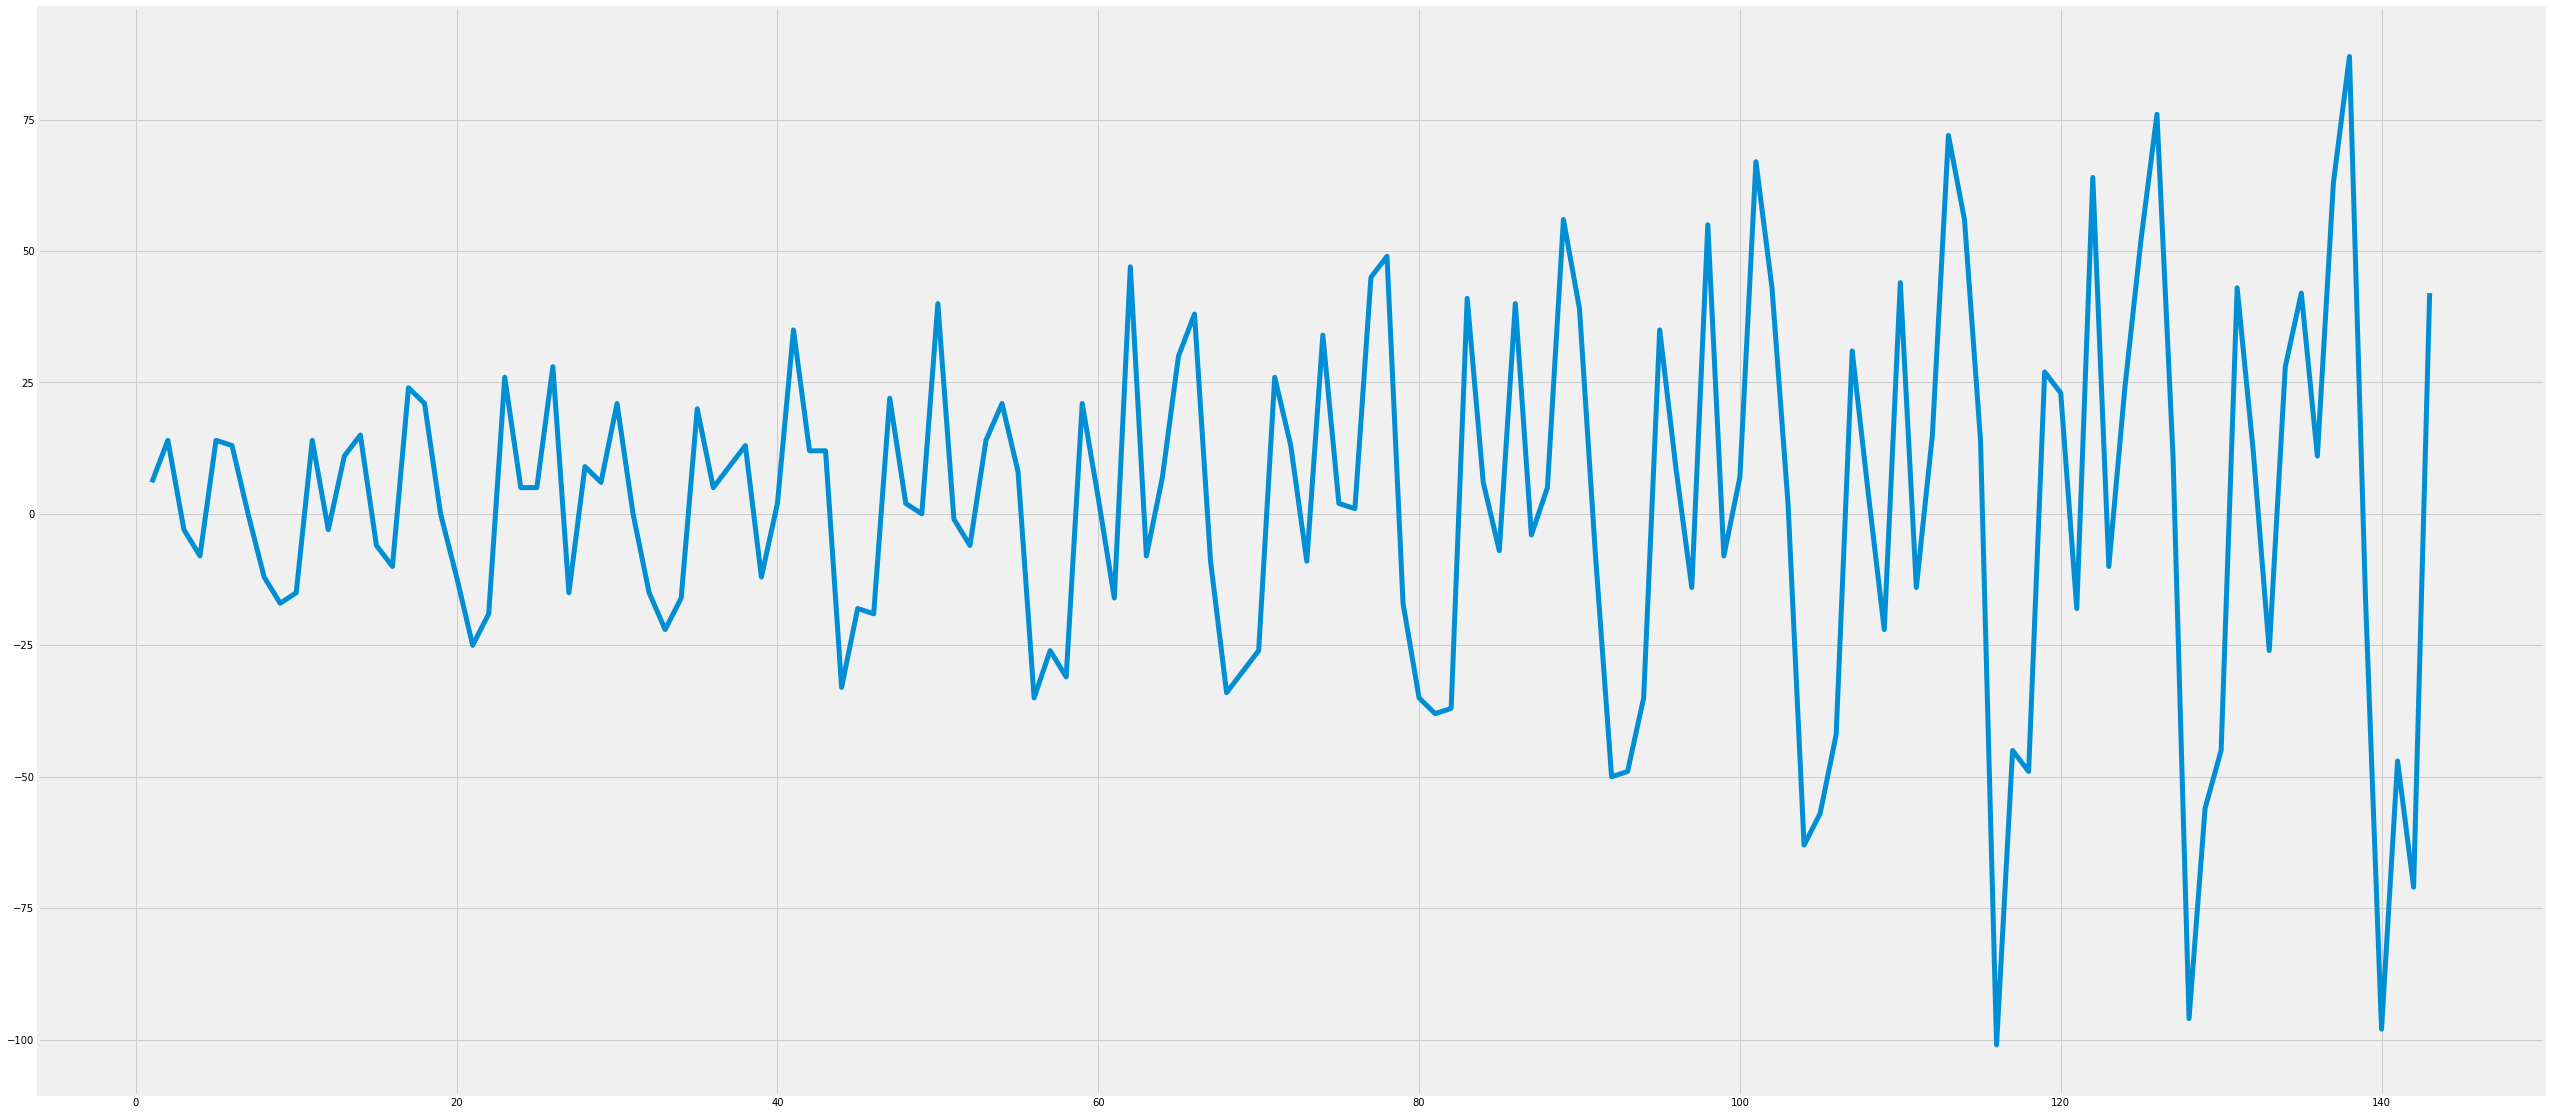

In [39]:
series['passengers3'] = series['passengers'].diff()
series.passengers3.plot()
plt.show()

As expected, differentiation removes the trend (oscillations happen around a fixed level), but variations amplitude is magnified.

In [40]:
result = adfuller(series.passengers3[10:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.830154
p-value: 0.054094


We continue moving in the right direction - what happens if we combine the two transformations?

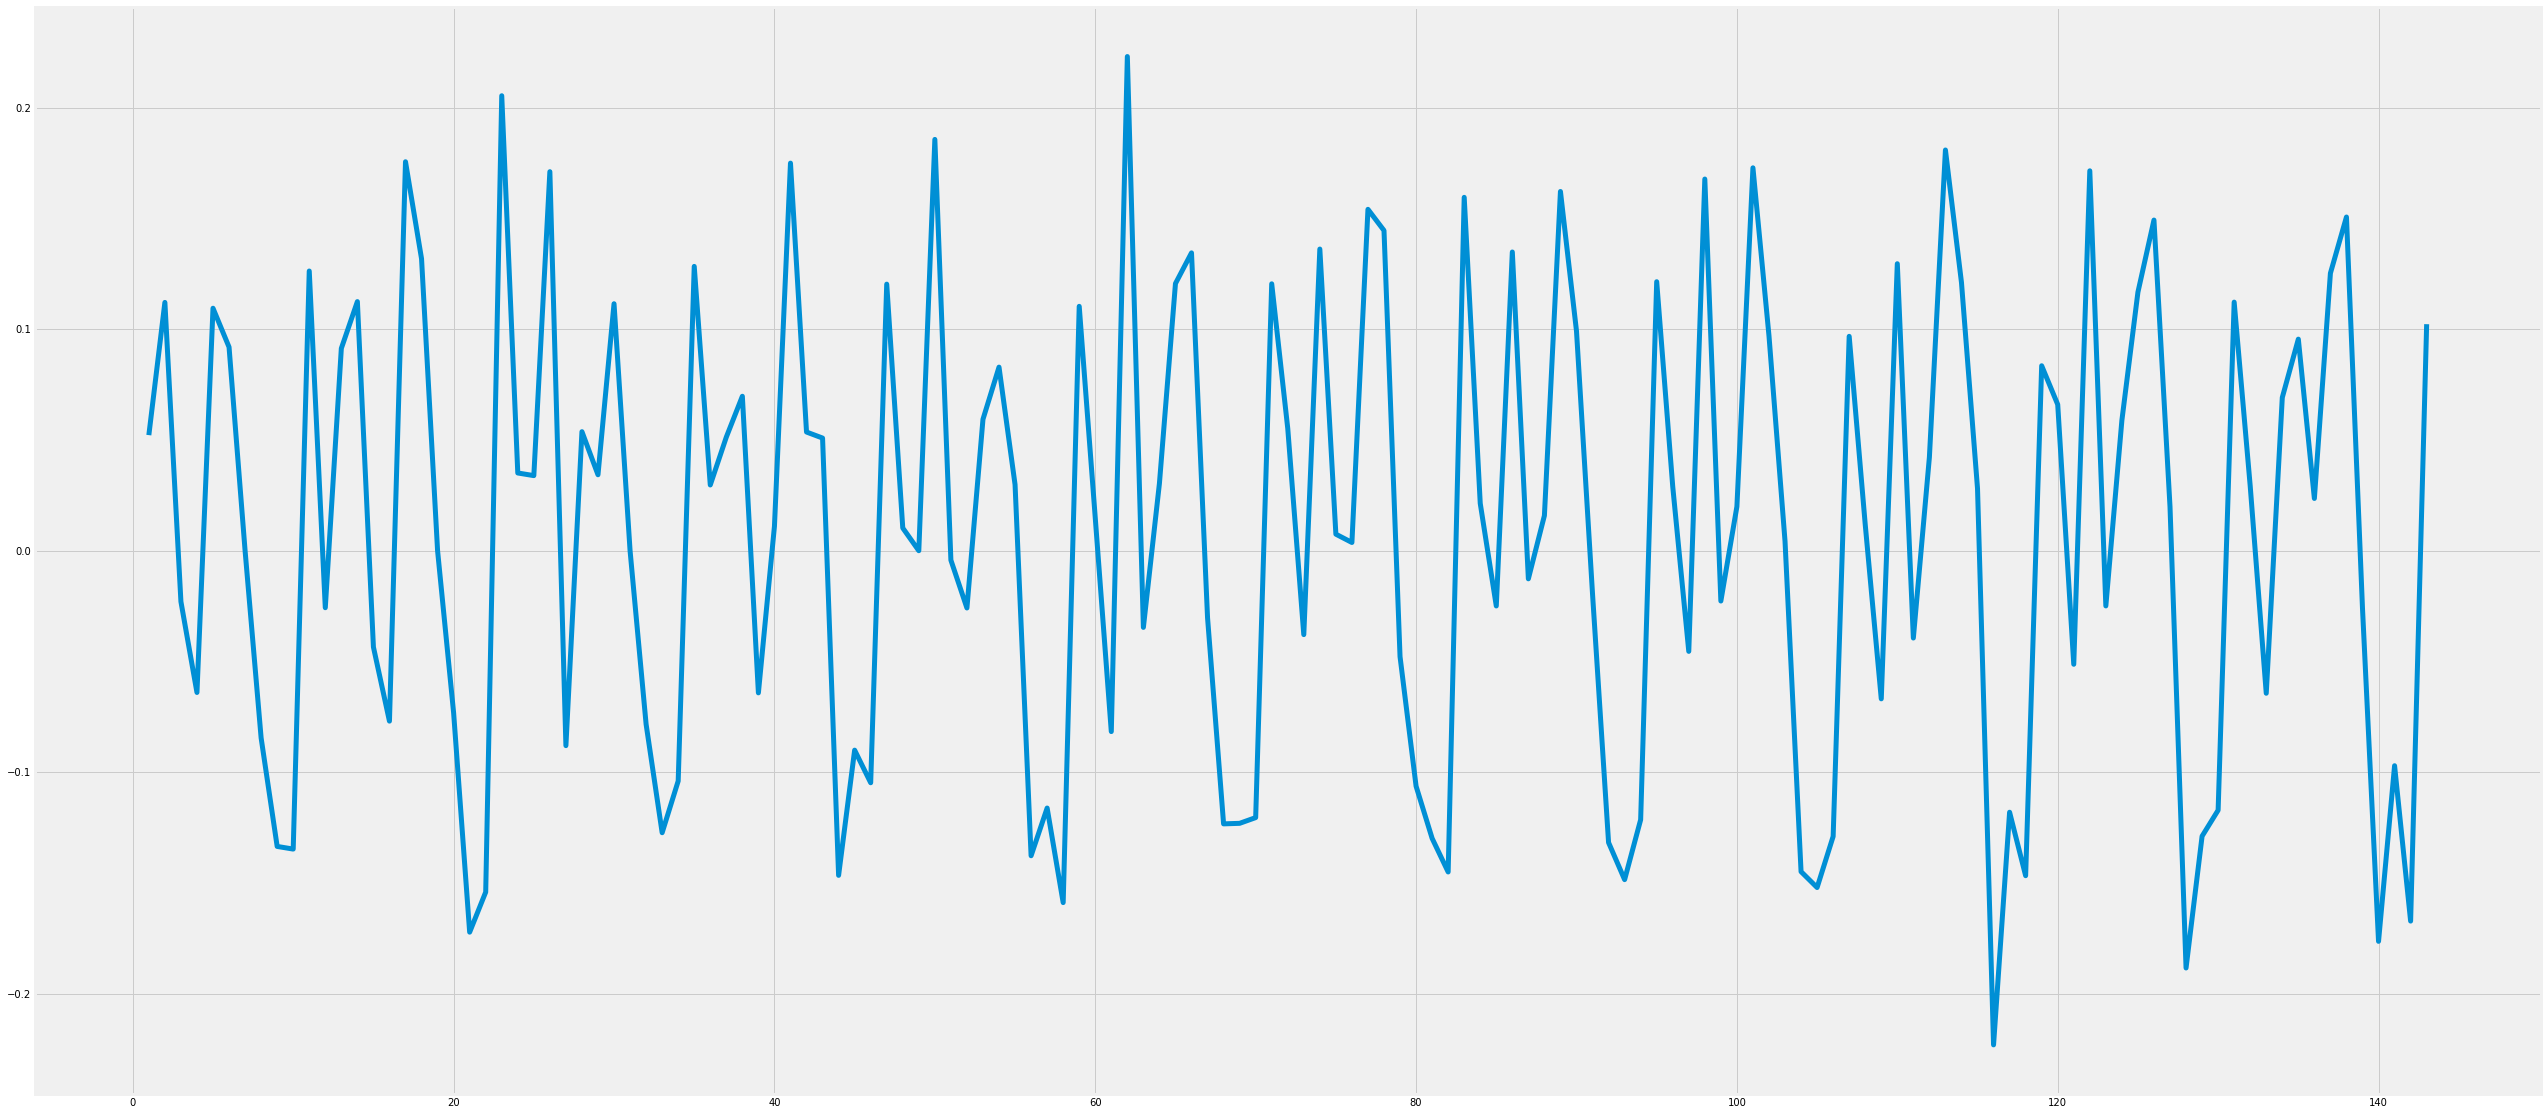

In [41]:
series['passengers4'] = series['passengers'].apply(np.log).diff()
series.passengers4.plot()
plt.show()

In [42]:
result = adfuller(series.passengers4[10:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.086110
p-value: 0.027598


So after applying logarithm (to stabilize the variance) and differentiation (to remove the trend), we have transformed our series to one that can be plausibly treated as stationary. We can verify that intuition by examining ACF and PACF:

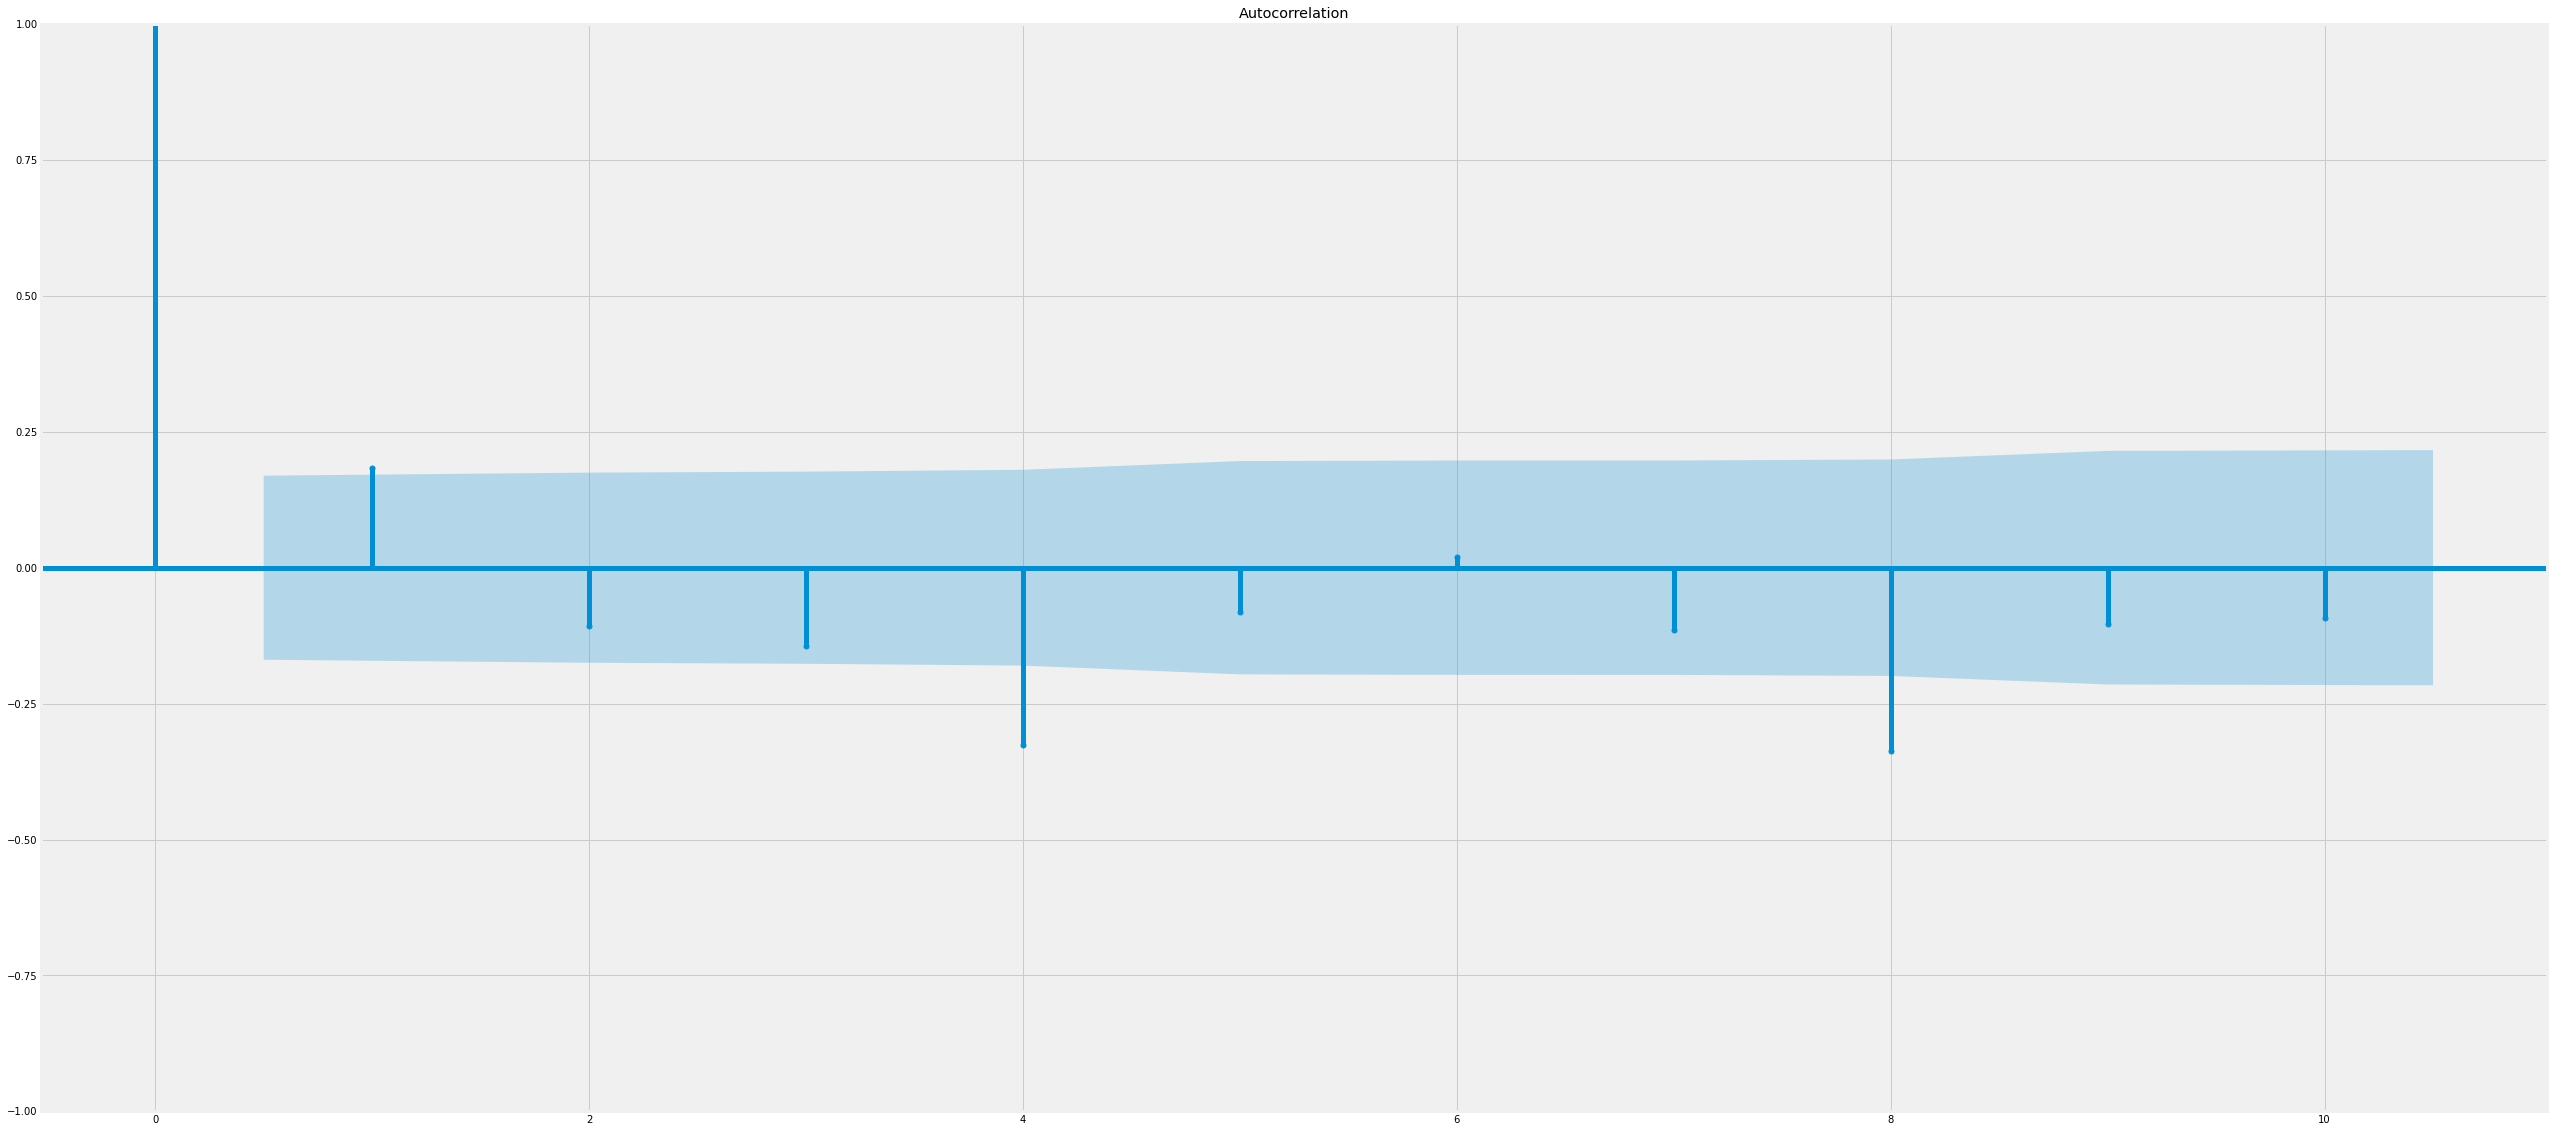

In [43]:
plot_acf(series['passengers4'][10:], lags = 10)
plt.show()

C:\Users\val-wd\AppData\Roaming\Python\Python39\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


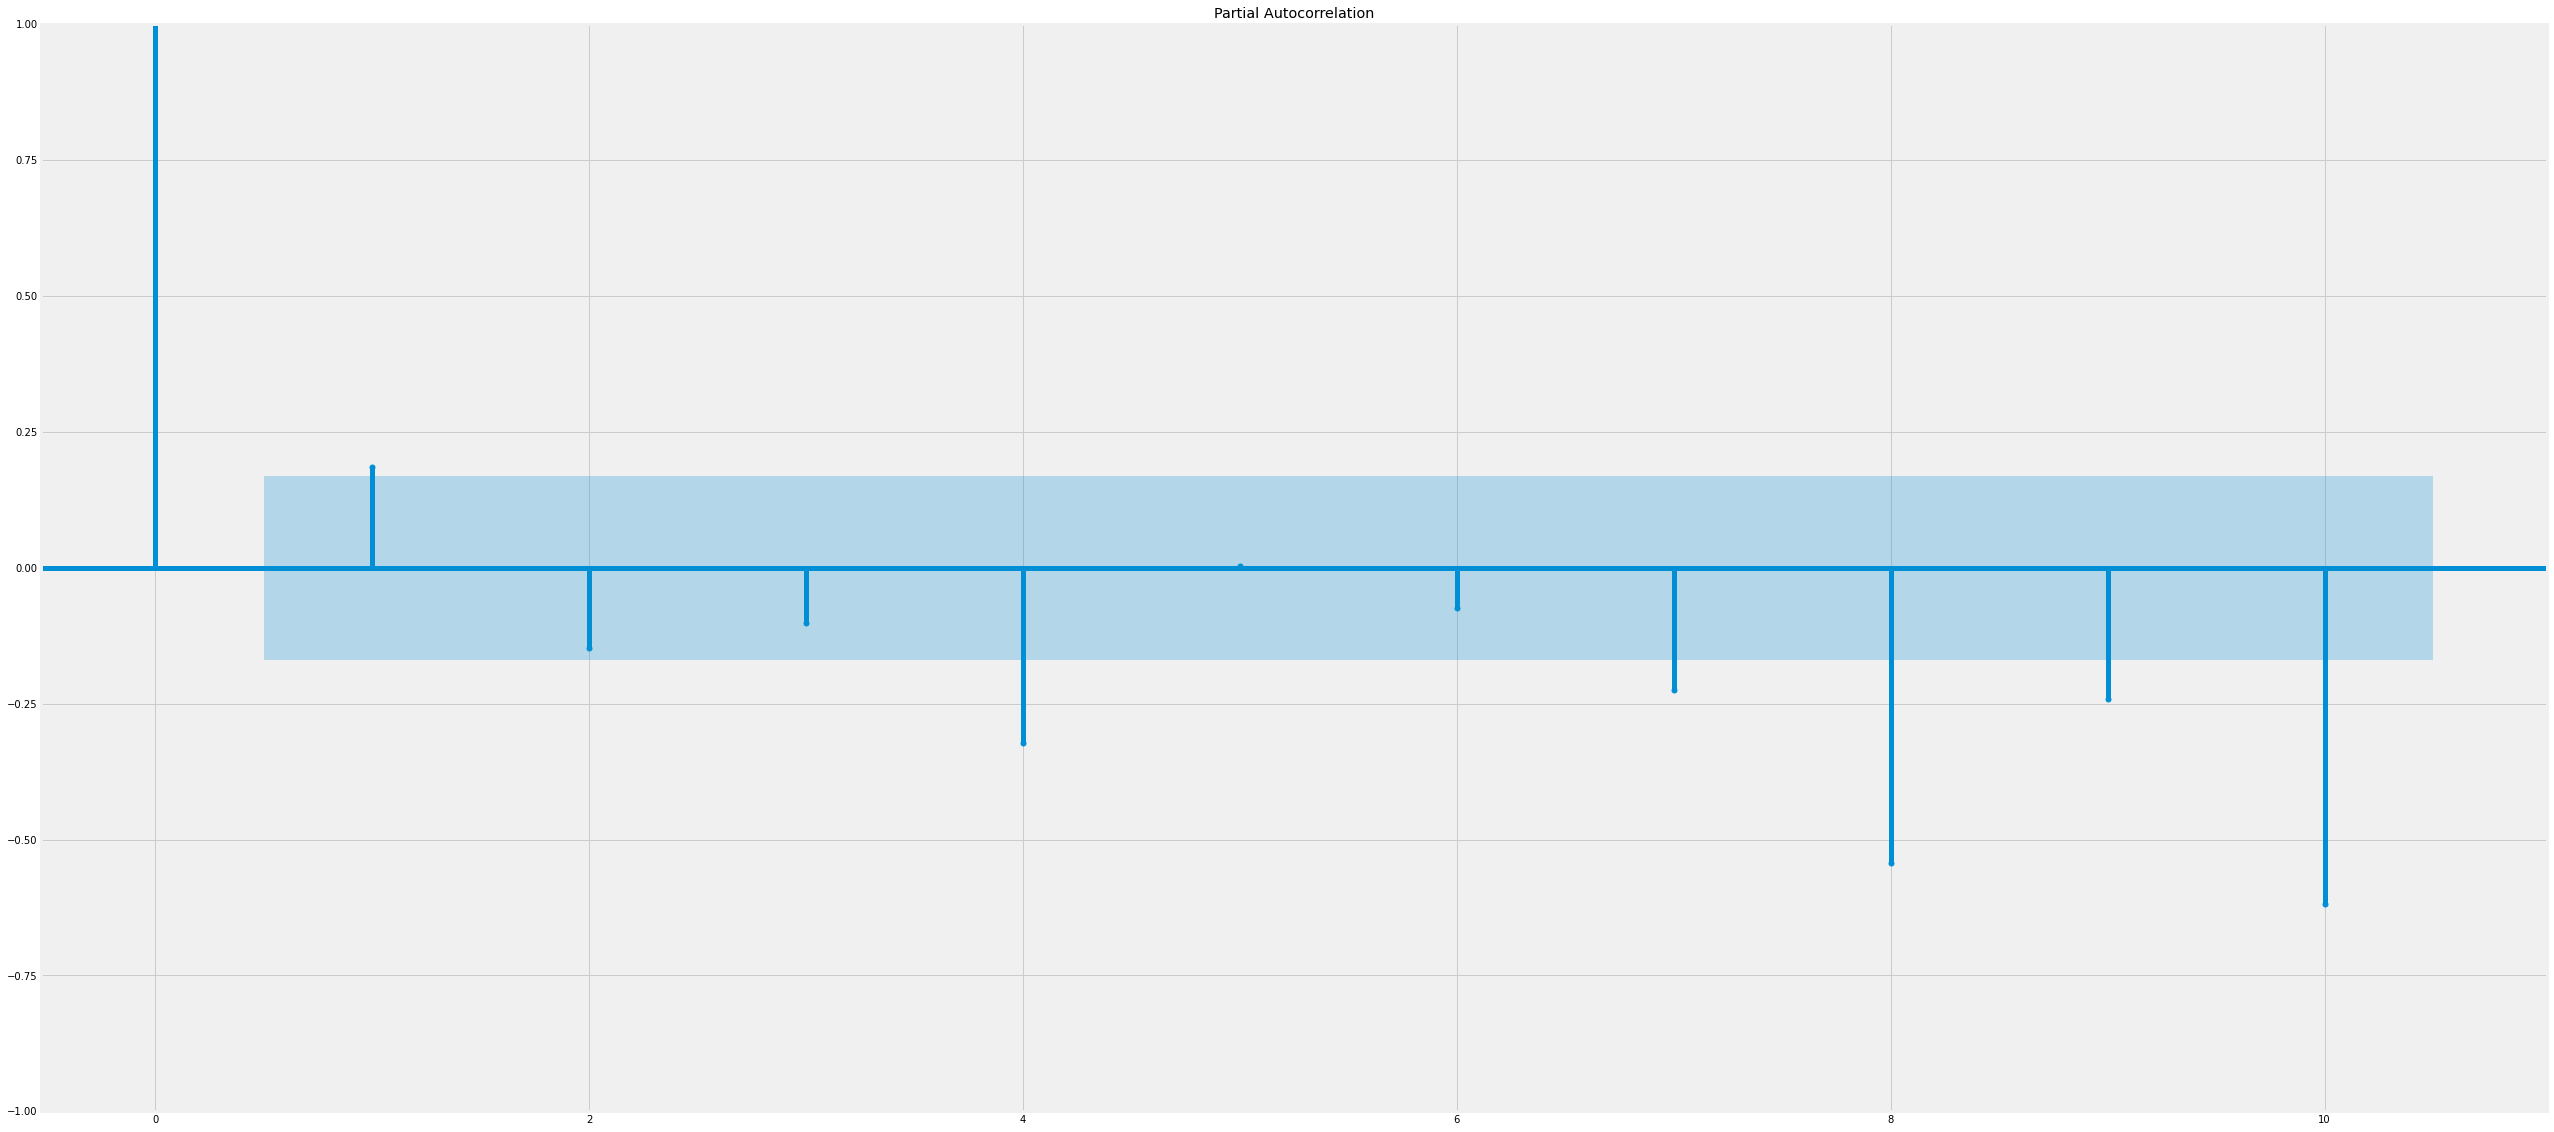

In [44]:
plot_pacf(series['passengers4'][10:], lags = 10)
plt.show()

<!-- TODO:
* lag plots
* moar explanations? -->

<!-- <a id="section-five"></a>
# Causality

MOAR: Granger causality test is used to determine if one time series will be useful to forecast another. It is based on the idea that if X causes Y, then the forecast of Y based on previous values of Y AND the previous values of X should outperform the forecast of Y based on previous values of Y alone.
So, Granger causality test should not be used to test if a lag of Y causes Y. Instead, it is generally used on exogenous (not Y lag) variables only. It is implemented in the statsmodel package.
It accepts a 2D array with 2 columns as the main argument. The values are in the first column and the predictor (X) is in the second column. The Null hypothesis is that the series in the second column, does not Granger cause the series in the first. If the P-Values are less than a significance level (0.05) then we reject the null hypothesis and conclude that the said lag of X is indeed useful. The second argument maxlag says till how many lags of Y should be included in the test.a -->